
# Accident severity prediction using classification

Crash severity prediction models enable various agencies to predict the severity of a crash to gain insights into the factors that affect or are associated with crash severity. 

### 1. Importing Essential Libraries 

In [1]:
import re
import time 
import numpy as np
import pandas as pd
import statistics
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline


time.time() method of Time module is used to get the time in seconds since epoch. The handling of leap seconds is platform dependent.

In [2]:
Start_time = time.time()

In [3]:
# Decorator used to monitor how long each step of the ML Pipeline takes to run 
def time_step(fn):
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = fn(*args, **kwargs)
    end_time = time.time()
    time_taken = round(end_time - start_time, 4)
    if time_taken < 60:
      print(f'{fn.__name__} took {time_taken} seconds to run')
    else :
      print(f'{fn.__name__} took {time_taken/60} minutes to run')
    return result
  return wrapper

### Data Preparation

Considering 2 tables with fewer features and evaluating the model

In [4]:
test_set_grp = pd.read_csv("test_set.csv")
train_set_grp = pd.read_csv("train_set.csv")

In [5]:
test_set_grp.drop(["accident_index"], axis=1 ,inplace=True )
train_set_grp.drop(["accident_index"], axis=1 ,inplace=True )

In [6]:
test_set_grp.head()

,day_of_week,sex_of_driver,age_of_driver,vehicle_type,journey_purpose_of_driver,driver_imd_decile,driver_home_area_type,age_band_of_driver,number_of_vehicles,number_of_casualties,road_type,speed_limit,accident_severity
0,7,1,22,3,6,5,1,5,2,1,1,20,3
1,3,1,63,9,6,7,1,9,2,2,6,30,3
2,7,3,47,9,6,2,1,8,3,1,2,20,2
3,4,1,55,11,1,8,1,8,1,2,2,20,2
4,2,1,70,9,6,10,2,10,2,1,6,30,3


In [7]:
train_set_grp.head()

,day_of_week,sex_of_driver,age_of_driver,vehicle_type,journey_purpose_of_driver,driver_imd_decile,driver_home_area_type,age_band_of_driver,number_of_vehicles,number_of_casualties,road_type,speed_limit,accident_severity
0,5,1,42,9,6,1,1,7,3,2,6,60,2
1,5,1,69,1,2,2,1,10,2,1,6,20,3
2,7,2,42,9,6,9,1,7,3,1,6,30,3
3,6,2,42,9,2,4,1,7,3,3,3,70,3
4,5,2,52,9,6,3,1,8,2,1,6,30,3


### Splitting Data into Training and Testing

The dataset is split into train and test data for training and testing the predictive model. Random sampling has been used as the splitting method.


In [8]:
# Importing necessary libraries
from numpy.ma.core import shape
from sklearn.model_selection import train_test_split

# Splitting into train and test set based on casualty severity as the target variable
x_accident_train_grp = train_set_grp.drop("accident_severity", axis=1)
x_accident_test_grp = test_set_grp.drop("accident_severity", axis=1)
y_accident_train_grp = train_set_grp["accident_severity"]
y_accident_test_grp = test_set_grp["accident_severity"]

In [9]:
# Shape of the resultant dataframes
print(x_accident_train_grp.shape)
print(x_accident_test_grp.shape)
print(y_accident_train_grp.shape)
print(y_accident_test_grp.shape)

(5123, 12)
(2343, 12)
(5123,)
(2343,)


### Setting up a baseline


In [10]:
from sklearn.model_selection import GridSearchCV
print(y_accident_train_grp.value_counts())

3    3919
2    1129
1      75
Name: accident_severity, dtype: int64


In [11]:
ef = [3] * 64674

### Decision Tree


In [12]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

In [13]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
#We will search for the best hyperparameters for the decision trees, using GridSearch
# and thus cross-validation. We give here several combinations for the hyperparameters to compare. 
model_grp = DecisionTreeClassifier()
model_grp.fit(x_accident_train_grp, y_accident_train_grp)
y_hat_grp = model_grp.predict(x_accident_test_grp)


In [14]:
# details on the best model for the decision tree algorithm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_accident_test_grp, y_hat_grp))
print(confusion_matrix(y_accident_test_grp, y_hat_grp))

              precision    recall  f1-score   support

           1       0.08      0.06      0.07        35
           2       0.27      0.28      0.27       545
           3       0.77      0.76      0.77      1763

    accuracy                           0.64      2343
   macro avg       0.37      0.37      0.37      2343
weighted avg       0.64      0.64      0.64      2343

[[   2   13   20]
 [   8  152  385]
 [  15  404 1344]]


In [15]:
from sklearn.metrics import accuracy_score
score_dt_grp = round(accuracy_score(y_hat_grp,y_accident_test_grp)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt_grp)+" %")

The accuracy score achieved using Decision Tree is: 63.94 %


### Random Forest model

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_grp = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 2 x 2 = 16 combinations in the grid
param_grid = {
    'n_estimators': [10, 200],
    'max_depth': [5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf_grp, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(x_accident_train_grp, y_accident_train_grp)
end = time.time() - start
print(f"Took {end} seconds")

Took 15.372056245803833 seconds


In [17]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=10,
                       random_state=7)

In [18]:
grid_search.best_score_

0.32204697404798455

In [19]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

4

In [20]:
rf_split_test_scores_grp = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    rf_split_test_scores_grp.append(val)

In [21]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
4,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.594947,0.322047,45.869635
6,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 10}",0.451530,0.305062,32.438312
7,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.402127,0.294293,26.815882
5,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.568042,0.294288,48.192514
0,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.300300,0.291329,2.987236
2,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}",0.296461,0.290825,1.901141
3,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}",0.294821,0.288896,2.009451
1,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.295870,0.288845,2.374465


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [23]:
import os
from joblib import dump
from joblib import load
# create a folder where all trained models will be kept
if not os.path.exists("models"): os.makedirs("models")
dump(grid_search.best_estimator_, 'models/rf_reg_grp.joblib')

['models/rf_reg_grp.joblib']

In [24]:
loaded_model_grp = load('models/rf_reg_grp.joblib')
y_hat_rf_grp = loaded_model_grp.predict(x_accident_test_grp)

In [25]:
print(classification_report(y_accident_test_grp, y_hat_rf_grp))
print(confusion_matrix(y_accident_test_grp, y_hat_rf_grp))

              precision    recall  f1-score   support

           1       1.00      0.03      0.06        35
           2       0.43      0.08      0.14       545
           3       0.76      0.97      0.85      1763

    accuracy                           0.75      2343
   macro avg       0.73      0.36      0.35      2343
weighted avg       0.69      0.75      0.68      2343

[[   1    3   31]
 [   0   46  499]
 [   0   58 1705]]


In [26]:
score_rf_grp = round(accuracy_score(y_hat_rf_grp,y_accident_test_grp)*100,2)

print("The accuracy score achieved using Random Forest is: "+str(score_rf_grp)+" %")

The accuracy score achieved using Random Forest is: 74.78 %


### SVM for classification

In [27]:
from sklearn.svm import LinearSVC

lsvm_grp = LinearSVC(random_state=7)

# specify the hyperparameters and their values
# 6 combinations in the grid
param_grid = {
    'C': [ 0.01, 0.1, 1, 5],
    'max_iter': [1000]
}

# we'll use 5-fold cross-validation
grid_search_grp = GridSearchCV(lsvm_grp, param_grid, cv=5, scoring='f1_macro', return_train_score=True) 

start = time.time()
grid_search_grp.fit(x_accident_train_grp, y_accident_train_grp)
end = time.time() - start
print(f"Took {end} seconds")

Took 12.338299751281738 seconds


In [28]:
grid_search_grp.best_estimator_

LinearSVC(C=1, random_state=7)

In [29]:
grid_search_grp.best_score_

0.3113938706555334

In [30]:
cv_results = pd.DataFrame(grid_search_grp.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,"{'C': 1, 'max_iter': 1000}",0.318381,0.311394,2.194731
1,"{'C': 0.1, 'max_iter': 1000}",0.289835,0.290830,-0.343403
0,"{'C': 0.01, 'max_iter': 1000}",0.289103,0.289523,-0.145090
3,"{'C': 5, 'max_iter': 1000}",0.255834,0.255488,0.135191


In [31]:
dump(grid_search_grp.best_estimator_, 'models/svm_reg_grp.joblib')

['models/svm_reg_grp.joblib']

In [32]:
loaded_model_svm_grp = load('models/svm_reg_grp.joblib')
y_hat_svm_grp = loaded_model_svm_grp.predict(x_accident_test_grp)

In [33]:
print(classification_report(y_accident_test_grp, y_hat_svm_grp))
print(confusion_matrix(y_accident_test_grp, y_hat_svm_grp))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00       545
           3       0.75      1.00      0.86      1763

    accuracy                           0.75      2343
   macro avg       0.25      0.33      0.29      2343
weighted avg       0.57      0.75      0.65      2343

[[   0    0   35]
 [   0    0  545]
 [   0    0 1763]]


In [34]:
score_svm_grp = round(accuracy_score(y_hat_svm_grp,y_accident_test_grp)*100,2)

print("The accuracy score achieved using SVM is: "+str(score_svm_grp)+" %")

The accuracy score achieved using SVM is: 75.25 %


## Conclusion

In [35]:
scores_grp = [score_svm_grp,score_dt_grp,score_rf_grp]
algorithms_grp = ["Support Vector Machine","Decision Tree","Random Forest"]    

for i in range(len(algorithms_grp)):
    print("The accuracy score achieved using "+algorithms_grp[i]+" is: "+str(scores_grp[i])+" %")

The accuracy score achieved using Support Vector Machine is: 75.25 %
The accuracy score achieved using Decision Tree is: 63.94 %
The accuracy score achieved using Random Forest is: 74.78 %


<AxesSubplot:xlabel='Algorithms', ylabel='Accuracy score'>

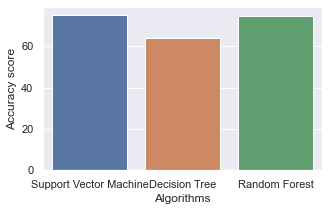

In [36]:
import seaborn as sns
sns.set(rc={'figure.figsize':(5,3)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms_grp,scores_grp)

The obtained results do not have good efficiency and the model does not have high accuracy, and among the presented models, Random Forest is superior to all models. In order to increase the efficiency of the model, other feature engineering techniques should be used, which are presented in the continuation of the notebook.

### **2.0 - Data Preparation**
**2.1 - Loading Data - UK Road Safety Data**

In this study, in order to maximize the quality of the model, we used 3 datasets that have the most important information related to road accidents, in order to obtain the best possible results with the most important possible features.
The datasets used were obtained from data.gov.uk and the datasets used are as follows:

*   dft-road-casualty-statistics-accident-2021.csv
*   dft-road-casualty-statistics-casualty-2021.csv
*   dft-road-casualty-statistics-vehicle-2021.csv



In [37]:
# Loading the datasets into dataframes
accident_df = pd.read_csv("dft-road-casualty-statistics-accident-2021.csv")
casualty_df = pd.read_csv("dft-road-casualty-statistics-casualty-2021.csv")
vehicle_df = pd.read_csv("dft-road-casualty-statistics-vehicle-2021.csv")

In [38]:
# Validating Accident Dataframe
accident_df.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2021010287148,2021,10287148,521508.0,193079.0,-0.246102,51.623425,1,3,3,...,0,4,7,4,1,0,1,1,2,E01000263
1,2021010287149,2021,10287149,535379.0,180783.0,-0.050574,51.509767,1,2,2,...,5,4,1,1,0,0,1,1,2,E01004303
2,2021010287151,2021,10287151,529701.0,170398.0,-0.136152,51.417769,1,2,2,...,5,4,1,1,0,0,1,1,2,E01003146
3,2021010287155,2021,10287155,525312.0,178385.0,-0.196411,51.490536,1,1,1,...,4,4,1,1,0,0,1,1,2,E01002847
4,2021010287157,2021,10287157,512144.0,171526.0,-0.388169,51.431649,1,3,4,...,0,4,1,1,0,0,1,1,2,E01002608


In [39]:
# Validating shape of Accident Dataframe
accident_df.shape

(101087, 36)

In [40]:
# Validating Casualty Dataframe
casualty_df.head()

,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,lsoa_of_casualty
0,2021010287148,2021,10287148,1,1,1,1,19,4,3,0,0,0,0,0,9,1,10,E01023551
1,2021010287149,2021,10287149,1,1,2,1,25,5,3,0,0,1,0,0,9,1,5,E01003955
2,2021010287149,2021,10287149,2,2,1,1,21,5,3,0,0,0,0,0,9,1,3,E01004202
3,2021010287149,2021,10287149,2,3,2,1,17,4,2,0,0,1,0,0,9,1,2,E01004295
4,2021010287151,2021,10287151,1,1,1,1,27,6,3,0,0,0,0,0,9,1,2,E01002056


In [41]:
# Validating shape of Casualty Dataframe
casualty_df.shape

(128209, 19)

In [42]:
# Validating Vehicle Dataframe
vehicle_df.head()

,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,...,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,lsoa_of_driver
0,2021010287148,2021,10287148,1,9,0,17,1,5,0,...,1,19,4,999,1,3,VOLKSWAGEN GOLF,10,1,E01023551
1,2021010287148,2021,10287148,2,9,0,2,0,0,0,...,3,-1,-1,1499,1,2,BMW 1 SERIES,-1,-1,-1
2,2021010287148,2021,10287148,3,9,0,2,0,0,0,...,3,-1,-1,-1,3,1,SMART FORTWO,-1,-1,-1
3,2021010287149,2021,10287149,1,9,0,18,3,7,0,...,1,32,6,2967,2,11,AUDI Q7,-1,-1,-1
4,2021010287149,2021,10287149,2,9,0,18,5,1,0,...,1,21,5,1598,1,11,VAUXHALL ASTRA,3,1,E01004202


In [43]:
# Validating shape of Vehicle Dataframe
vehicle_df.shape

(186443, 28)

### **3.0 Creating the New Feature Dataframe**

We can use common features (columns) between datasets to unify our datasets, the Casualty and Vehicle Dataframe has the following features in common:

*   accident_index
*   accident_year
*   accidnet_reference
*   vehicle_reference


In [44]:
merged_df = pd.merge(vehicle_df,casualty_df, on=["accident_reference","accident_index","accident_year","vehicle_reference"], how="right")

In the following, we will use the obtained dataset and the accident dataset to obtain the main framework of our work.

In [45]:
df = pd.merge(merged_df,accident_df, on=["accident_reference","accident_index","accident_year"], how="right")

The dropna() method removes the rows that contains NULL values.


In [46]:
# Dropping rows with NaN values
df.dropna(inplace=True)

In [47]:
# Validating the newly created dataframe
df.head()

,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2021010287148,2021,10287148,1.0,9.0,0.0,17.0,1.0,5.0,0.0,...,0,4,7,4,1,0,1,1,2,E01000263
1,2021010287149,2021,10287149,1.0,9.0,0.0,18.0,3.0,7.0,0.0,...,5,4,1,1,0,0,1,1,2,E01004303
2,2021010287149,2021,10287149,2.0,9.0,0.0,18.0,5.0,1.0,0.0,...,5,4,1,1,0,0,1,1,2,E01004303
3,2021010287149,2021,10287149,2.0,9.0,0.0,18.0,5.0,1.0,0.0,...,5,4,1,1,0,0,1,1,2,E01004303
4,2021010287151,2021,10287151,1.0,9.0,0.0,6.0,7.0,7.0,0.0,...,5,4,1,1,0,0,1,1,2,E01003146


In [48]:
# Validating the shape of newly created dataframe
df.shape

(80966, 76)

**3.1 Preliminary Data Analysis**

Because our dataset is very large, we need to select the important features in order to take the best possible features and the most relevant ones to train the model.

Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the Pandas Dataframe in Python.

In [49]:
# Correlation scores for accident_severity
corr = df.corr().round(2)
print(corr['accident_severity'].sort_values().to_string())

speed_limit                                   -0.14
number_of_casualties                          -0.14
urban_or_rural_area                           -0.13
casualty_reference                            -0.10
latitude                                      -0.10
location_northing_osgr                        -0.10
light_conditions                              -0.08
police_force                                  -0.08
age_of_casualty                               -0.06
pedestrian_location                           -0.06
age_band_of_casualty                          -0.06
casualty_class                                -0.06
age_band_of_driver                            -0.04
age_of_driver                                 -0.04
pedestrian_movement                           -0.04
road_type                                     -0.03
journey_purpose_of_driver                     -0.02
vehicle_type                                  -0.02
driver_home_area_type                         -0.02
casualty_hom

**3.2 New Dataframe after Preliminary Analysis:**

In [50]:
# Droping duplicates from dataframe df
df.drop_duplicates(inplace=True)
# Resetting indices
df.reset_index(inplace=True)
# Creation of new dataframe
df_filtered = df[["first_point_of_impact", "trunk_road_flag", "urban_or_rural_area", "number_of_casualties",
                         "speed_limit", "age_band_of_casualty", "vehicle_leaving_carriageway", "light_conditions",
                         "local_authority_district", "casualty_class", "age_band_of_driver", "latitude","longitude",
                         "road_type", "driver_home_area_type", "age_of_vehicle", "skidding_and_overturning",
                         "driver_imd_decile", "vehicle_type", "engine_capacity_cc", "weather_conditions",
                         "number_of_vehicles", "vehicle_location_restricted_lane",
                      "junction_location", "second_road_class", "junction_control", "sex_of_casualty",
                         "sex_of_driver","did_police_officer_attend_scene_of_accident","casualty_severity","accident_severity"]]

In [51]:
# Validating latest dataframe
df_filtered.head()

,first_point_of_impact,trunk_road_flag,urban_or_rural_area,number_of_casualties,speed_limit,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,local_authority_district,casualty_class,...,number_of_vehicles,vehicle_location_restricted_lane,junction_location,second_road_class,junction_control,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity,accident_severity
0,1.0,2,1,1,30,4.0,0.0,4,-1,1.0,...,3,0.0,1.0,6,4,1.0,1.0,1,3.0,3
1,1.0,2,1,3,30,5.0,0.0,4,-1,2.0,...,2,0.0,8.0,3,2,1.0,1.0,1,3.0,2
2,1.0,2,1,3,30,5.0,0.0,4,-1,1.0,...,2,0.0,1.0,3,2,1.0,1.0,1,3.0,2
3,1.0,2,1,3,30,4.0,0.0,4,-1,2.0,...,2,0.0,1.0,3,2,1.0,1.0,1,2.0,2
4,4.0,2,1,4,30,6.0,0.0,4,-1,1.0,...,2,0.0,2.0,5,2,1.0,1.0,1,3.0,2


In [52]:
# Validating shape of dataframe
df_filtered.shape

(80966, 31)

**3.3 Variable Notes**

The variables are narrowed down into 2 main types:
*   Categorical : Variables containing value indicating a category.
*   Numeric : Variables containing numeric values.

### **4.0 Further Data Preprocessing**

In the continuation of data pre-processing, we have to impute missing or unrelated data, so first we convert this type of data to Nan. Writing this function helps us to specify a list of out-of-range data so that we can identify this data in each column and place it as Nan.

In [53]:
# Function which replaces missing or unknown values with NaN
def initialising_nan(dataframe, column_name, value_data):
    for value in value_data:
        dataframe.loc[dataframe[column_name] == value, column_name] = np.nan

guideline :
* first_point_of_impact	0	Did not impact
* first_point_of_impact	1	Front
* first_point_of_impact	2	Back
* first_point_of_impact	3	Offside
* first_point_of_impact	4	Nearside
* first_point_of_impact	9	unknown (self reported)
* first_point_of_impact	-1	Data missing or out of range

In [54]:
# "First point of impact"
# =======================
# identifying the missing and unknown values
print(df_filtered["first_point_of_impact"].value_counts())
# modifying missing and unknown values in first point of impact feature
# modifying the missing and unknown values by null values for succeeding imputation
initialising_nan(df_filtered, "first_point_of_impact", [-1, 9]) 

 1.0    39816
 2.0    14136
 3.0    10438
 4.0     9933
 0.0     3031
 9.0     2889
-1.0      723
Name: first_point_of_impact, dtype: int64


"Trunk road flag"

* trunk_road_flag	1	Trunk (Roads managed by Highways England)
* trunk_road_flag	2	Non-trunk
* trunk_road_flag	-1	Data missing or out of range

In [55]:
# "Trunk road flag"
# =================
# identifying the missing and unknown values
print(df_filtered["trunk_road_flag"].value_counts())
# modifying the missing and unknown values by null values for succeeding imputation
initialising_nan(df_filtered, "trunk_road_flag", [-1])


 2    69700
-1     5859
 1     5407
Name: trunk_road_flag, dtype: int64


"Urban or rural area"

* urban_or_rural_area	1	Urban
* urban_or_rural_area	2	Rural
* urban_or_rural_area	3	Unallocated

In [56]:
# "Urban or rural area"
# =====================
# Identifying the missing and unknown values
print(df_filtered["urban_or_rural_area"].value_counts())
# since there are no missing and unknown values there is no data cleaning required

1    54668
2    26298
Name: urban_or_rural_area, dtype: int64


"Speed limit"

* speed_limit		
* speed_limit	-1	Data missing or out of range
* speed_limit	99	unknown (self reported)

In [57]:
# "Speed limit"
# =============
# identifying the missing and unknown values
print(df_filtered["speed_limit"].value_counts())
# modifying the missing and unknown values by null values for succeeding imputation
initialising_nan(df_filtered, "speed_limit", [-1])

30    44133
20    11070
60    10880
40     6796
70     4375
50     3712
Name: speed_limit, dtype: int64


"Age band of casualty"

* age_band_of_driver	1:	0 - 5
* age_band_of_driver	2:	6 - 10
* age_band_of_driver	3:	11 - 15
* age_band_of_driver	4:	16 - 20
* age_band_of_driver	5:	21 - 25
* age_band_of_driver	6:	26 - 35
* age_band_of_driver	7:	36 - 45
* age_band_of_driver	8:	46 - 55
* age_band_of_driver	9:	56 - 65
* age_band_of_driver	10:	66 - 75
* age_band_of_driver	11:	Over 75
* age_band_of_driver	-1:	Data missing or out of range

In [58]:
# "Age band of casualty"
# ======================
# identifying the missing and unknown values
print(df_filtered["age_band_of_casualty"].value_counts())
# modifying the missing and unknown values by null values for succeeding imputation
initialising_nan(df_filtered, "age_band_of_casualty", [-1])

 6.0     17948
 7.0     12428
 8.0     10549
 5.0      9617
 4.0      8172
 9.0      7089
 3.0      3585
 10.0     3563
 11.0     2748
 2.0      2084
-1.0      1851
 1.0      1332
Name: age_band_of_casualty, dtype: int64


"Vehicle leaving carriageway"

* vehicle_leaving_carriageway	0	Did not leave carriageway
* vehicle_leaving_carriageway	1	Nearside
* vehicle_leaving_carriageway	2	Nearside and rebounded
* vehicle_leaving_carriageway	3	Straight ahead at junction
* vehicle_leaving_carriageway	4	Offside on to central reservation
* vehicle_leaving_carriageway	5	Offside on to centrl res + rebounded
* vehicle_leaving_carriageway	6	Offside - crossed central reservation
* vehicle_leaving_carriageway	7	Offside
* vehicle_leaving_carriageway	8	Offside and rebounded
* vehicle_leaving_carriageway	9	unknown (self reported)
* vehicle_leaving_carriageway	-1	Data missing or out of range

In [59]:
# "Vehicle leaving carriageway"
# ============================
# identifying the missing and unknown values
print(df_filtered["vehicle_leaving_carriageway"].value_counts())
# modifying the missing and unknown values by null values for succeeding imputation
initialising_nan(df_filtered, "vehicle_leaving_carriageway", [-1])

 0.0    61737
 1.0     6590
 9.0     6043
 7.0     3414
 2.0      847
 3.0      630
-1.0      605
 8.0      404
 4.0      355
 5.0      207
 6.0      134
Name: vehicle_leaving_carriageway, dtype: int64


Similarly, all the categorical data feautres will be changed in this manner.

* light_conditions	1	Daylight
* light_conditions	4	Darkness - lights lit
* light_conditions	5	Darkness - lights unlit
* light_conditions	6	Darkness - no lighting
* light_conditions	7	Darkness - lighting unknown
* light_conditions	-1	Data missing or out of range

In [60]:
# "Light conditions"
print(df_filtered["light_conditions"].value_counts())
# ==================
initialising_nan(df_filtered, "light_conditions", [-1])

 1    59218
 4    15682
 6     3989
 7     1524
 5      540
-1       13
Name: light_conditions, dtype: int64


In [61]:
# "Local authority district"
# ==========================
df_filtered = df_filtered.drop("local_authority_district", axis=1)
# Since the are too many coloumns to be considered in local authority district, it is dropped.

* casualty_class	1	Driver or rider
* casualty_class	2	Passenger
* casualty_class	3	Pedestrian

In [62]:
# "Casualty class"
# ================
# identifying the missing and unknown values
print(df_filtered["casualty_class"].value_counts())
# since there are no missing and unknown values there is no data cleaning required

1.0    55026
2.0    15340
3.0    10600
Name: casualty_class, dtype: int64


* age_band_of_driver	1:	0 - 5
* age_band_of_driver	2:	6 - 10
* age_band_of_driver	3:	11 - 15
* age_band_of_driver	4:	16 - 20
* age_band_of_driver	5:	21 - 25
* age_band_of_driver	6:	26 - 35
* age_band_of_driver	7:	36 - 45
* age_band_of_driver	8:	46 - 55
* age_band_of_driver	9:	56 - 65
* age_band_of_driver	10:	66 - 75
* age_band_of_driver	11:	Over 75
* age_band_of_driver	-1:	Data missing or out of range

In [63]:
# " Age band of driver "
# ======================
initialising_nan(df_filtered, "age_band_of_driver", [-1])

In [64]:
# "Latitude"
# ==========
# Identifying the missing and unknown values
print(df_filtered["latitude"].value_counts())
# since there are no missing and unknown values there is no data cleaning required

51.870306    22
52.988833    10
51.625231    10
51.380590     9
53.173428     8
             ..
54.959714     1
54.994815     1
54.976068     1
54.912143     1
58.981288     1
Name: latitude, Length: 62479, dtype: int64


In [65]:
# "Longitude"
# ===========
# Identifying the missing and unknown values
print(df_filtered["longitude"].value_counts())
# since there are no missing and unknown values there is no data cleaning required

-4.712942    22
-1.101535    10
-0.060309    10
-1.674368    10
-1.959838     9
             ..
-1.458518     1
-1.440487     1
-1.629359     1
-1.672579     1
-2.973248     1
Name: longitude, Length: 62870, dtype: int64


* road_type	1	Roundabout
* road_type	2	One way street
* road_type	3	Dual carriageway
* road_type	6	Single carriageway
* road_type	7	Slip road
* road_type	9	Unknown
* road_type	12	One way street/Slip road
* road_type	-1	Data missing or out of range

In [66]:
# "Road type"
# ===========
initialising_nan(df_filtered, "road_type", [9,-1])

* driver_home_area_type	1	Urban area
* driver_home_area_type	2	Small town
* driver_home_area_type	3	Rural
* driver_home_area_type	-1	Data missing or out of range

In [67]:
# "Driver home area type"
# =======================
initialising_nan(df_filtered, "driver_home_area_type", [-1])

-1	Undefined

In [68]:
# "Age of vehicle"
# ================
initialising_nan(df_filtered, "age_of_vehicle", [-1])

* skidding_and_overturning	0	None
* skidding_and_overturning	1	Skidded
* skidding_and_overturning	2	Skidded and overturned
* skidding_and_overturning	3	Jackknifed
* skidding_and_overturning	4	Jackknifed and overturned
* skidding_and_overturning	5	Overturned
* skidding_and_overturning	9	unknown (self reported)
* skidding_and_overturning	-1	Data missing or out of range

In [69]:
# "Skidding and overturning"
# ==========================
initialising_nan(df_filtered, "skidding_and_overturning", [-1, 9])

* driver_imd_decile	1	Most deprived 10%
* driver_imd_decile	2	More deprived 10-20%
* driver_imd_decile	3	More deprived 20-30%
* driver_imd_decile	4	More deprived 30-40%
* driver_imd_decile	5	More deprived 40-50%
* driver_imd_decile	6	Less deprived 40-50%
* driver_imd_decile	7	Less deprived 30-40%
* driver_imd_decile	8	Less deprived 20-30%
* driver_imd_decile	9	Less deprived 10-20%
* driver_imd_decile	10	Least deprived 10%
* driver_imd_decile	-1	Data missing or out of range

In [70]:
# "Driver imd decile"
# ===================
initialising_nan(df_filtered, "driver_imd_decile", [-1])

In [71]:
# "Vehicle type"
# ==============
# Identifying the missing and unknown values
df_filtered = df_filtered.drop("vehicle_type", axis=1)
# Since the are too many coloumns to be considered in vehicle type, it is dropped.

* engine_capacity_cc	-1	Data missing or out of range

In [72]:
# "Engine capacity cc"
# ====================
initialising_nan(df_filtered, "engine_capacity_cc", [-1])

* weather_conditions	1	Fine no high winds
* weather_conditions	2	Raining no high winds
* weather_conditions	3	Snowing no high winds
* weather_conditions	4	Fine + high winds
* weather_conditions	5	Raining + high winds
* weather_conditions	6	Snowing + high winds
* weather_conditions	7	Fog or mist
* weather_conditions	8	Other
* weather_conditions	9	Unknown
* weather_conditions	-1	Data missing or out of range

In [73]:
# "Weather conditions"
# ====================
initialising_nan(df_filtered, "weather_conditions", [-1, 9])

In [74]:
# "Number of vehicles"
# ====================
# Identifying the missing and unknown values
print(df_filtered["number_of_vehicles"].value_counts())
# Since there are no outliers and no removal required

2     51810
1     19614
3      7174
4      1609
5       485
6       195
7        37
8        21
9        10
10        8
11        3
Name: number_of_vehicles, dtype: int64


* vehicle_location_restricted_lane	0	On main c'way - not in restricted lane
* vehicle_location_restricted_lane	1	Tram/Light rail track
* vehicle_location_restricted_lane	2	Bus lane
* vehicle_location_restricted_lane	3	Busway (including guided busway)
* vehicle_location_restricted_lane	4	Cycle lane (on main carriageway)
* vehicle_location_restricted_lane	5	Cycleway or shared use footway (not part of  main carriageway)
* vehicle_location_restricted_lane	6	On lay-by or hard shoulder
* vehicle_location_restricted_lane	7	Entering lay-by or hard shoulder
* vehicle_location_restricted_lane	8	Leaving lay-by or hard shoulder
* vehicle_location_restricted_lane	9	Footway (pavement)
* vehicle_location_restricted_lane	10	Not on carriageway
* vehicle_location_restricted_lane	99	unknown (self reported)
* vehicle_location_restricted_lane	-1	Data missing or out of range

In [75]:
# "Vehicle Location Restricted Lane"
# ==================================
initialising_nan(df_filtered, "vehicle_location_restricted_lane", [-1, 99])

* junction_location	0	Not at or within 20 metres of junction
* junction_location	1	Approaching junction or waiting/parked at junction approach
* junction_location	2	Cleared junction or waiting/parked at junction exit
* junction_location	3	Leaving roundabout
* junction_location	4	Entering roundabout
* junction_location	5	Leaving main road
* junction_location	6	Entering main road
* junction_location	7	Entering from slip road
* junction_location	8	Mid Junction - on roundabout or on main road
* junction_location	9	unknown (self reported)
* junction_location	-1	Data missing or out of range


In [76]:
# "Junction Location"
# ===================
initialising_nan(df_filtered, "junction_location", [-1, 9])

* second_road_class	0	Not at junction or within 20 metres
* second_road_class	1	Motorway
* second_road_class	2	A(M)
* second_road_class	3	A
* second_road_class	4	B
* second_road_class	5	C
* second_road_class	6	Unclassified
* second_road_class	-1	Data missing or out of range

In [77]:
# "Second road class"
# ===================
# Identifying the missing and unknown values
print(df_filtered["second_road_class"].value_counts())
# ==================================
initialising_nan(df_filtered, "second_road_class", [-1])

 6    33584
 0    32426
 3     8843
 4     3246
 5     2489
 1      272
-1       88
 2       18
Name: second_road_class, dtype: int64


In [78]:
# "Junction Control"
# ==================
# Identifying the missing and unknown values
print(df_filtered["junction_control"].value_counts())
# Since there are a lot of missing values, it will be dropped
df_filtered = df_filtered.drop("junction_control", axis=1)

 4    36150
-1    32862
 2     9786
 9     1414
 3      510
 1      244
Name: junction_control, dtype: int64


* sex_of_casualty	1	Male
* sex_of_casualty	2	Female
* sex_of_casualty	9	unknown (self reported)
* sex_of_casualty	-1	Data missing or out of range

* sex_of_driver	1	Male
* sex_of_driver	2	Female
* sex_of_driver	3	Not known
* sex_of_driver	-1	Data missing or out of range

In [79]:
# "Sex of Casualty"
# ==================
initialising_nan(df_filtered, "sex_of_casualty", [-1, 9])
# "Sex of Driver"
# ==================
initialising_nan(df_filtered, "sex_of_driver", [-1, 3])

* did_police_officer_attend_scene_of_accident	1	Yes
* did_police_officer_attend_scene_of_accident	2	No
* did_police_officer_attend_scene_of_accident	3	No - accident was reported using a self completion  form (self rep only)
* did_police_officer_attend_scene_of_accident	-1	Data missing or out of range

In [80]:
# "Did Police Officer Attend Scene of Accident"
# ==============================================
initialising_nan(df_filtered, "did_police_officer_attend_scene_of_accident", [-1])
# the value of 3 in this categorical dataset is close to 2 hence modifying the dataset
df_filtered.loc[df_filtered["did_police_officer_attend_scene_of_accident"] == 3,
                "did_police_officer_attend_scene_of_accident"] = 2

Feature with an outlier:

In [81]:
# "Number of casualties"
# ======================
# Identifying the outliers
print(df_filtered["number_of_casualties"].value_counts())

1     52243
2     16702
3      6795
4      2948
5      1330
6       444
7       357
8        96
22       22
10       20
9         9
Name: number_of_casualties, dtype: int64


The Seaborn displot() function provides a figure-level interface for creating categorical plots.

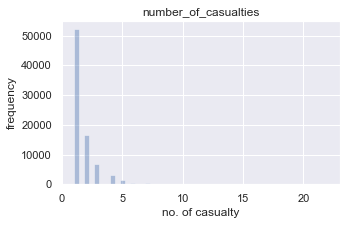

In [82]:
# Histogram
# Define plot object
hist = sns.distplot(df_filtered.loc[:, 'number_of_casualties'].astype(float), kde=False)
# Setting graph title
hist.set_title('number_of_casualties')
hist.set(xlabel='no. of casualty', ylabel='frequency')
plt.show()
# Removing outliers
df_filtered = df_filtered[df_filtered.number_of_casualties != 41]

In [83]:
# Checking if the outlier got removed
print(df_filtered["number_of_casualties"].value_counts())

1     52243
2     16702
3      6795
4      2948
5      1330
6       444
7       357
8        96
22       22
10       20
9         9
Name: number_of_casualties, dtype: int64


### **5.0 Splitting Data into Training and Testing**

In [84]:
pd.set_option('display.max_columns', None)
print(df_filtered.shape)
df_filtered.head()

(80966, 28)


,first_point_of_impact,trunk_road_flag,urban_or_rural_area,number_of_casualties,speed_limit,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,latitude,longitude,road_type,driver_home_area_type,age_of_vehicle,skidding_and_overturning,driver_imd_decile,engine_capacity_cc,weather_conditions,number_of_vehicles,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity,accident_severity
0,1.0,2.0,1,1,30.0,4.0,0.0,4.0,1.0,4.0,51.623425,-0.246102,6.0,1.0,3.0,2.0,10.0,999.0,7.0,3,0.0,1.0,6.0,1.0,1.0,1.0,3.0,3
1,1.0,2.0,1,3,30.0,5.0,0.0,4.0,2.0,6.0,51.509767,-0.050574,3.0,NaN,11.0,0.0,NaN,2967.0,1.0,2,0.0,8.0,3.0,1.0,1.0,1.0,3.0,2
2,1.0,2.0,1,3,30.0,5.0,0.0,4.0,1.0,5.0,51.509767,-0.050574,3.0,1.0,11.0,0.0,3.0,1598.0,1.0,2,0.0,1.0,3.0,1.0,1.0,1.0,3.0,2
3,1.0,2.0,1,3,30.0,4.0,0.0,4.0,2.0,5.0,51.509767,-0.050574,3.0,1.0,11.0,0.0,3.0,1598.0,1.0,2,0.0,1.0,3.0,1.0,1.0,1.0,2.0,2
4,4.0,2.0,1,4,30.0,6.0,0.0,4.0,1.0,6.0,51.417769,-0.136152,6.0,1.0,4.0,0.0,2.0,1998.0,1.0,2,0.0,2.0,5.0,1.0,1.0,1.0,3.0,2


In [85]:
# Importing necessary libraries
from numpy.ma.core import shape
from sklearn.model_selection import train_test_split

# Converting the data set into predictor and target variables based on accident severity as target
X_accident = df_filtered.drop("accident_severity", axis=1)
y_accident = df_filtered["accident_severity"]

# Splitting into train and test set based on casualty severity as the target variable
x_accident_train, x_accident_test, y_accident_train, y_accident_test = \
train_test_split(X_accident, y_accident, test_size=0.3, random_state=42)

Using the shape module in the numpy library

In [86]:
# Shape of the resultant dataframes
print(x_accident_train.shape)
print(x_accident_test.shape)
print(y_accident_train.shape)
print(y_accident_test.shape)

(56676, 27)
(24290, 27)
(56676,)
(24290,)


### **6. Desriptive Statisitics on Training Dataset**



In [87]:
# Function for plotting numerical variables
# ==========================================
def numerical_plot(dataframe, column_name):
    pd.DataFrame(dataframe.loc[:, column_name].describe())
    heading = column_name.replace('_', ' ')
    fig = plt.figure(figsize=(15, 5))
    # Histogram
    plt.subplot(1, 2, 1)
    # Define plot object
    hist = sns.distplot(x_accident_train.loc[:, column_name], bins=100)
    # Setting graph title
    hist.set_title('Average {}'.format(heading))
    hist.set(xlabel='{}'.format(heading), ylabel='Frequency')
    # Boxplot
    plt.subplot(1, 2, 2)
    # Define plot object
    box = sns.boxplot(x_accident_train.loc[:, column_name])
    # Setting graph title
    box.set_title('Average {}'.format(heading))
    box.set(xlabel='{}'.format(heading), ylabel='Frequency')
    # Showing the plot
    plt.show()

In [88]:
# Function for plotting categorical variables
# ============================================
def categorical_plot(dataframe, column_name, labels, bins):
    heading = column_name.replace('_', ' ')
    plot_usage_dataframe = pd.cut(dataframe[column_name], bins=bins, labels=labels)
    # Plotting the bar graph to display the frequency of impact on each portion of the vehicle
    plot_usage_dataframe.value_counts().plot(kind='bar')
    plt.title(label=column_name)
    plt.xlabel(xlabel='{}'.format(heading))
    plt.ylabel(ylabel='Frequency')
    plt.show()


**6.1 Dependent Variable**

accident_severity 

**6.2 Numeric Independent Variables**


**6.2.1 Number of Casualties**

In [89]:
pd.DataFrame(x_accident_train.number_of_casualties.describe())

,number_of_casualties
count,56676.000000
mean,1.617334
std,1.111108
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,22.000000


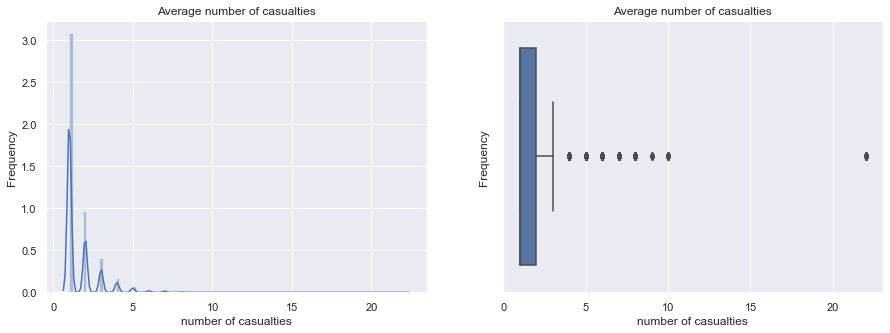

In [90]:
numerical_plot(x_accident_train,'number_of_casualties')

The average number of casualties is between 1 and 3. The outliers are above 20 casualties.

**6.2.2 Speed Limit**

In [91]:
pd.DataFrame(x_accident_train.speed_limit.describe())

,speed_limit
count,56676.000000
mean,36.554803
std,14.291126
min,20.000000
25%,30.000000
50%,30.000000
75%,40.000000
max,70.000000


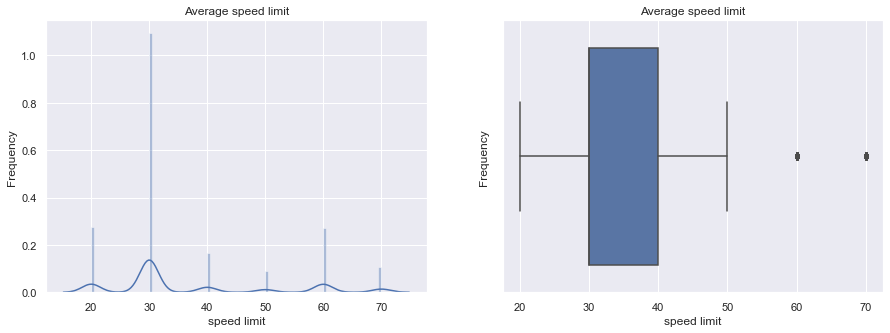

In [92]:
numerical_plot(x_accident_train, 'speed_limit')

**6.2.3 Age of Vehicle**

In [93]:
pd.DataFrame(x_accident_train.age_of_vehicle.describe())

,age_of_vehicle
count,37340.000000
mean,8.353964
std,5.677918
min,0.000000
25%,4.000000
50%,8.000000
75%,12.000000
max,89.000000


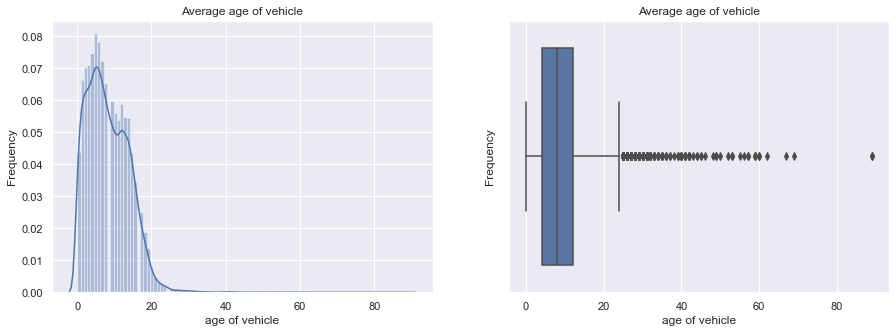

In [94]:
numerical_plot(x_accident_train, 'age_of_vehicle')

**6.2.4 Engine Capacity (cc)**

In [95]:
pd.DataFrame(x_accident_train.engine_capacity_cc.describe())

,engine_capacity_cc
count,37071.000000
mean,1616.062556
std,1238.761607
min,48.000000
25%,1198.000000
50%,1499.000000
75%,1968.000000
max,16400.000000


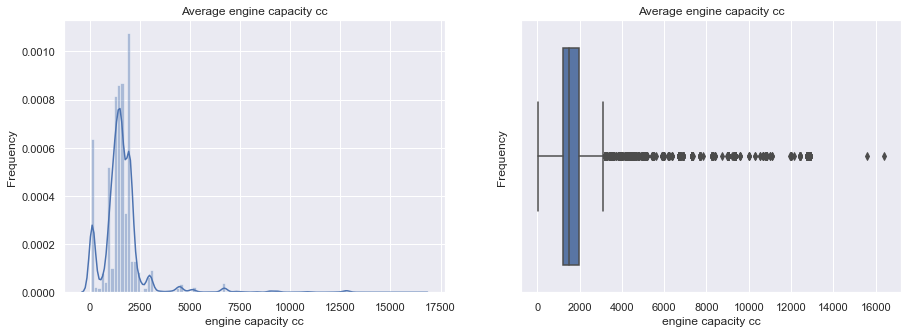

In [96]:
numerical_plot(x_accident_train, 'engine_capacity_cc')

**6.2.5 Number of Vehicles**

In [97]:
pd.DataFrame(x_accident_train.number_of_vehicles.describe())

,number_of_vehicles
count,56676.000000
mean,1.915502
std,0.727485
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,11.000000


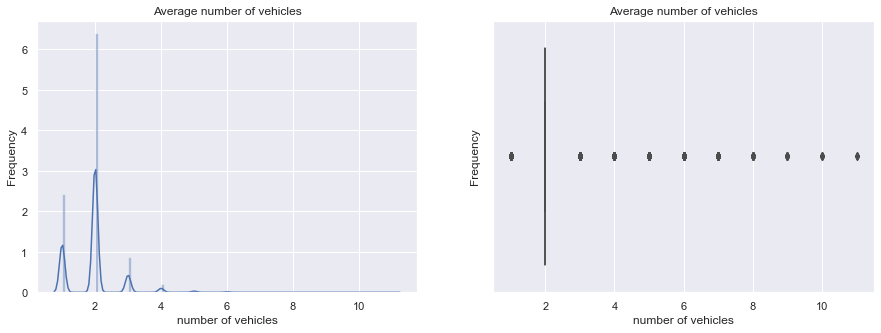

In [98]:
numerical_plot(x_accident_train, 'number_of_vehicles')

**6.3 Categorical Independent Variables**

**6.3.1 First Point of Impact**

In [99]:
pd.DataFrame(x_accident_train.first_point_of_impact.describe())

,first_point_of_impact
count,54125.000000
mean,1.790818
std,1.127518
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,4.000000


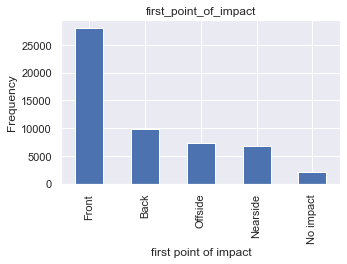

In [100]:
categorical_plot(x_accident_train, 'first_point_of_impact',
                  ['No impact', 'Front', 'Back', 'Offside', 'Nearside'], 5)

**6.3.2 Trunk Road Flag**

In [101]:
pd.DataFrame(x_accident_train.trunk_road_flag.describe())

,trunk_road_flag
count,52573.000000
mean,1.928728
std,0.257282
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,2.000000


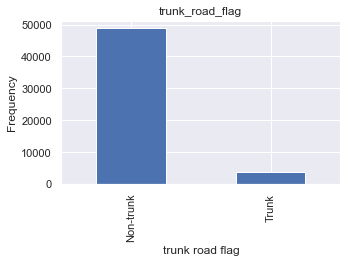

In [102]:
categorical_plot(x_accident_train, 'trunk_road_flag', ['Trunk', 'Non-trunk'], 2)

**6.3.3 Urban or Rural Area**

In [103]:
pd.DataFrame(x_accident_train.urban_or_rural_area.describe())

,urban_or_rural_area
count,56676.000000
mean,1.323753
std,0.467911
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


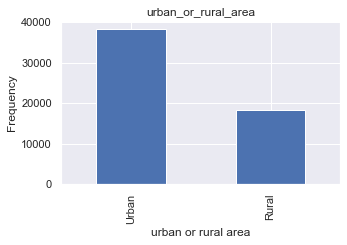

In [104]:
categorical_plot(x_accident_train, 'urban_or_rural_area', ['Urban', 'Rural'], 2)

**6.3.4 Age Band of Casualty**

In [105]:
pd.DataFrame(x_accident_train.age_band_of_casualty.describe())

,age_band_of_casualty
count,55423.000000
mean,6.382765
std,2.170596
min,1.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,11.000000


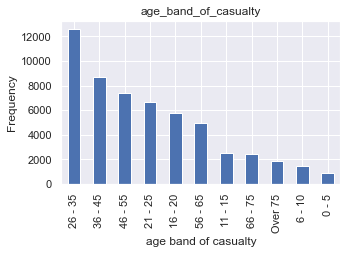

In [106]:
categorical_plot(x_accident_train, 'age_band_of_casualty', ["0 - 5", "6 - 10", "11 - 15", "16 - 20", "21 - 25",
                                                                "26 - 35", "36 - 45", "46 - 55", "56 - 65", "66 - 75",
                                                                "Over 75"], 11)

**6.3.5 Vehicle Leaving Carriageway**

In [107]:
pd.DataFrame(x_accident_train.vehicle_leaving_carriageway.describe())

,vehicle_leaving_carriageway
count,56250.000000
mean,1.184782
std,2.741791
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


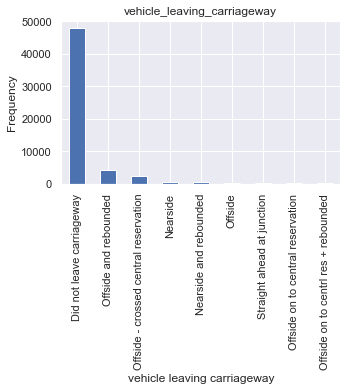

In [108]:
categorical_plot(x_accident_train, 'vehicle_leaving_carriageway', ["Did not leave carriageway", "Nearside",
                                                                       "Nearside and rebounded",
                                                                       "Straight ahead at junction",
                                                                       "Offside on to central reservation",
                                                                       "Offside on to centrl res + rebounded",
                                                                       "Offside - crossed central reservation",
                                                                       "Offside", "Offside and rebounded"], 9)

**6.3.6 Light Conditions**

In [109]:
pd.DataFrame(x_accident_train.light_conditions.describe())

,light_conditions
count,56665.000000
mean,1.973282
std,1.686987
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,7.000000


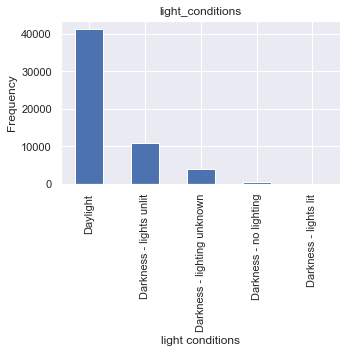

In [110]:
categorical_plot(x_accident_train, 'light_conditions', ["Daylight", "Darkness - lights lit",
                                                            "Darkness - lights unlit", "Darkness - no lighting",
                                                            "Darkness - lighting unknown"], 5)

**6.3.7 Casualty Class**

In [111]:
pd.DataFrame(x_accident_train.casualty_class.describe())

,casualty_class
count,56676.000000
mean,1.452696
std,0.715179
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


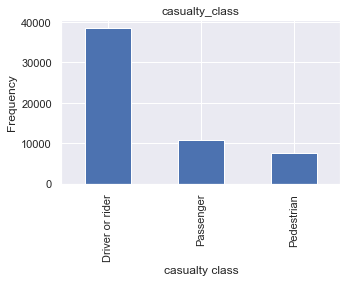

In [112]:
categorical_plot(x_accident_train, 'casualty_class', ["Driver or rider", "Passenger", "Pedestrian"], 3)

**6.3.8 Age Band of Driver**

In [113]:
pd.DataFrame(x_accident_train.age_band_of_driver.describe())

,age_band_of_driver
count,53829.000000
mean,6.751602
std,1.801047
min,1.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,11.000000


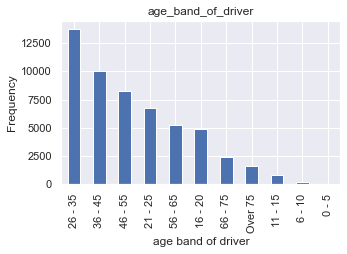

In [114]:
categorical_plot(x_accident_train, 'age_band_of_driver', ["0 - 5", "6 - 10", "11 - 15", "16 - 20", "21 - 25",
                                                              "26 - 35", "36 - 45", "46 - 55", "56 - 65", "66 - 75",
                                                              "Over 75"], 11)

**6.3.9 Road Type**

In [115]:
pd.DataFrame(x_accident_train.road_type.describe())

,road_type
count,55173.000000
mean,5.140069
std,1.615160
min,1.000000
25%,6.000000
50%,6.000000
75%,6.000000
max,7.000000


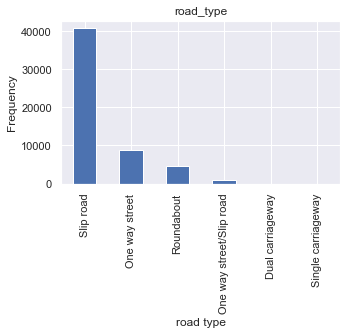

In [116]:
categorical_plot(x_accident_train, 'road_type', ["Roundabout", "One way street", "Dual carriageway",
                                                     "Single carriageway", "Slip road", "One way street/Slip road"], 6)

**6.3.10 Driver Home Area Type**

In [117]:
pd.DataFrame(x_accident_train.driver_home_area_type.describe())

,driver_home_area_type
count,50195.000000
mean,1.269389
std,0.621232
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


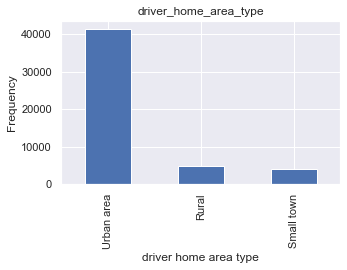

In [118]:
categorical_plot(x_accident_train, 'driver_home_area_type', ["Urban area", "Small town", "Rural"], 3)

**6.3.11 Skidding and Overturning**

In [119]:
pd.DataFrame(x_accident_train.skidding_and_overturning.describe())

,skidding_and_overturning
count,51869.000000
mean,0.367136
std,1.096114
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


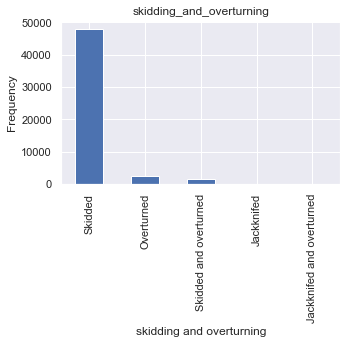

In [120]:
categorical_plot(x_accident_train, 'skidding_and_overturning',
                     ['Skidded', 'Skidded and overturned', 'Jackknifed', 'Jackknifed and overturned', 'Overturned'], 5)

**6.3.12 Driver imd Decile**

In [121]:
pd.DataFrame(x_accident_train.skidding_and_overturning.describe())

,skidding_and_overturning
count,51869.000000
mean,0.367136
std,1.096114
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


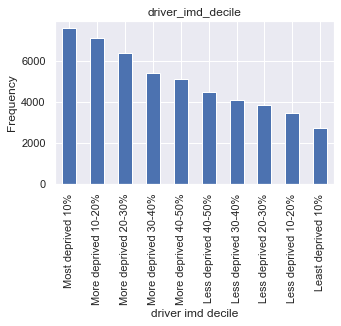

In [122]:
categorical_plot(x_accident_train, 'driver_imd_decile',
                     ['Most deprived 10%', 'More deprived 10-20%', 'More deprived 20-30%', 'More deprived 30-40%',
                      'More deprived 40-50%', 'Less deprived 40-50%', 'Less deprived 30-40%', 'Less deprived 20-30%',
                      'Less deprived 10-20%', 'Least deprived 10%'], 10)

**6.3.13 Weather Conditions**

In [123]:
pd.DataFrame(x_accident_train.weather_conditions.describe())

,weather_conditions
count,55066.000000
mean,1.457796
std,1.421351
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,8.000000


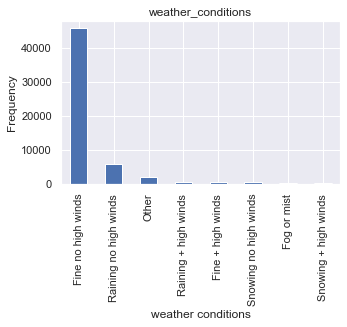

In [124]:
categorical_plot(x_accident_train, 'weather_conditions',
                     ["Fine no high winds", "Raining no high winds", "Snowing no high winds", "Fine + high winds",
                      "Raining + high winds", "Snowing + high winds", "Fog or mist", "Other"], 8)

**6.3.14 Vehicle Location Restricted Lane**

In [125]:
pd.DataFrame(x_accident_train.vehicle_location_restricted_lane.describe())

,vehicle_location_restricted_lane
count,52014.000000
mean,0.265909
std,1.409578
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


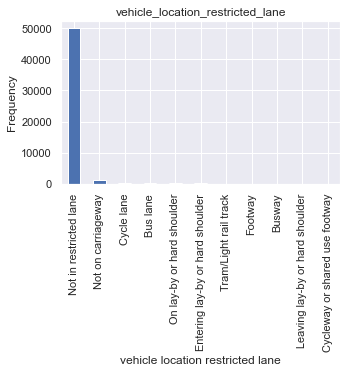

In [126]:
categorical_plot(x_accident_train, 'vehicle_location_restricted_lane',
                     ["Not in restricted lane", "Tram/Light rail track", "Bus lane", "Busway", "Cycle lane",
                      "Cycleway or shared use footway", "On lay-by or hard shoulder",
                      "Entering lay-by or hard shoulder", "Leaving lay-by or hard shoulder", "Footway",
                      "Not on carriageway"], 11)

**6.3.15 Junction Location**

In [127]:
pd.DataFrame(x_accident_train.junction_location.describe())

,junction_location
count,53055.000000
mean,2.300650
std,3.068915
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,8.000000


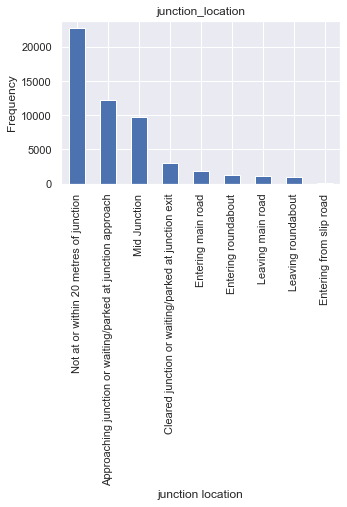

In [128]:
categorical_plot(x_accident_train, 'junction_location',
                     ["Not at or within 20 metres of junction",
                      "Approaching junction or waiting/parked at junction approach",
                      "Cleared junction or waiting/parked at junction exit", "Leaving roundabout", "Entering roundabout"
                         , "Leaving main road", "Entering main road", "Entering from slip road", "Mid Junction"], 9)

**6.3.16 Second Road Class**


In [129]:
pd.DataFrame(x_accident_train.second_road_class.describe())

,second_road_class
count,56613.000000
mean,3.144084
std,2.737909
min,0.000000
25%,0.000000
50%,3.000000
75%,6.000000
max,6.000000


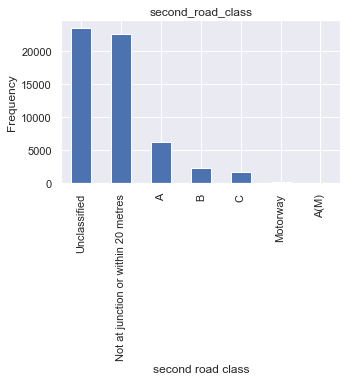

In [130]:
categorical_plot(x_accident_train, 'second_road_class',
                     ["Not at junction or within 20 metres", "Motorway", "A(M)", "A", "B", "C", "Unclassified"], 7)

**6.3.17 Sex of Casualty**


In [131]:
pd.DataFrame(x_accident_train.sex_of_casualty.describe())

,sex_of_casualty
count,56152.000000
mean,1.369177
std,0.482586
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


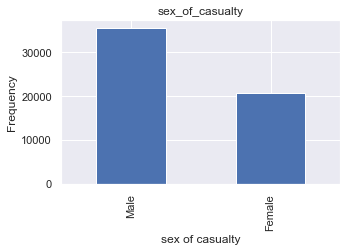

In [132]:
categorical_plot(x_accident_train, 'sex_of_casualty', ["Male", "Female"], 2)

**6.3.18 Did Police Officer Attend Scene of Accident**

In [133]:
pd.DataFrame(x_accident_train.did_police_officer_attend_scene_of_accident.describe())

,did_police_officer_attend_scene_of_accident
count,56676.000000
mean,1.291852
std,0.454619
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


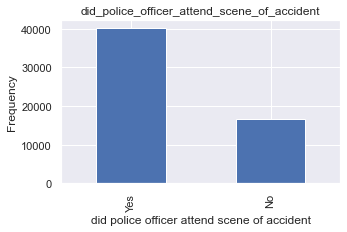

In [134]:
categorical_plot(x_accident_train, 'did_police_officer_attend_scene_of_accident', ["Yes", "No"], 2)

**6.3.19 Casualty Severity**

In [135]:
pd.DataFrame(x_accident_train.casualty_severity.describe())

,casualty_severity
count,56676.000000
mean,2.801080
std,0.428482
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,3.000000


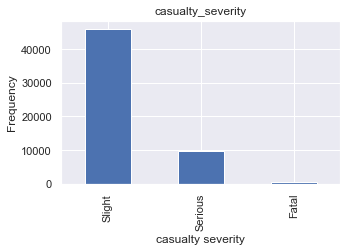

In [136]:
categorical_plot(x_accident_train, 'casualty_severity', ["Fatal", "Serious", "Slight"], 3)

**6.4 Special Variables**

The numeric variables Longitude and Latitude can be used to map out the various locations in which accidents have occurred.

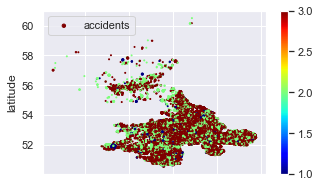

In [137]:
# Plotting the accident severity observed using latitude and longitude
x_accident_train.plot(kind="scatter", x="longitude", y="latitude", s=x_accident_train["number_of_casualties"],
                      label="accidents", alpha=1, c=y_accident_train, cmap=plt.get_cmap("jet"), colorbar=True, )
plt.legend()
plt.show()

In [138]:
pd.set_option('display.max_columns', None)
print(x_accident_train.shape)
x_accident_train.head()

(56676, 27)


,first_point_of_impact,trunk_road_flag,urban_or_rural_area,number_of_casualties,speed_limit,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,latitude,longitude,road_type,driver_home_area_type,age_of_vehicle,skidding_and_overturning,driver_imd_decile,engine_capacity_cc,weather_conditions,number_of_vehicles,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity
21886,2.0,2.0,1,2,30.0,8.0,0.0,1.0,2.0,9.0,53.536100,-2.585330,6.0,1.0,7.0,0.0,5.0,1995.0,2.0,2,0.0,0.0,0.0,2.0,2.0,2.0,3.0
39542,1.0,2.0,2,2,30.0,5.0,7.0,6.0,2.0,6.0,53.982409,-0.217750,6.0,3.0,15.0,2.0,3.0,1149.0,1.0,1,0.0,0.0,0.0,2.0,2.0,1.0,3.0
13564,4.0,2.0,1,2,30.0,7.0,0.0,1.0,2.0,10.0,51.531375,-0.230913,6.0,1.0,11.0,0.0,4.0,1910.0,1.0,2,0.0,8.0,6.0,1.0,1.0,1.0,3.0
23207,3.0,2.0,1,1,20.0,4.0,0.0,4.0,1.0,4.0,53.388390,-2.101856,6.0,1.0,NaN,0.0,8.0,NaN,2.0,2,0.0,8.0,6.0,1.0,1.0,1.0,3.0
71284,2.0,2.0,1,2,60.0,9.0,0.0,1.0,1.0,9.0,51.818130,-2.278071,3.0,1.0,NaN,0.0,3.0,NaN,1.0,5,0.0,0.0,0.0,2.0,2.0,1.0,2.0


In [139]:
pd.set_option('display.max_columns', None)
print(x_accident_test.shape)
x_accident_test.head()

(24290, 27)


,first_point_of_impact,trunk_road_flag,urban_or_rural_area,number_of_casualties,speed_limit,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,latitude,longitude,road_type,driver_home_area_type,age_of_vehicle,skidding_and_overturning,driver_imd_decile,engine_capacity_cc,weather_conditions,number_of_vehicles,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity
71908,1.0,2.0,1,1,20.0,5.0,0.0,1.0,3.0,8.0,51.171366,-1.779121,6.0,1.0,2.0,0.0,9.0,1498.0,1.0,1,0.0,1.0,3.0,2.0,2.0,1.0,3.0
54887,3.0,2.0,2,1,50.0,4.0,7.0,1.0,1.0,4.0,53.488842,-0.936873,6.0,3.0,13.0,0.0,8.0,1896.0,1.0,2,0.0,8.0,6.0,1.0,1.0,1.0,3.0
12258,NaN,2.0,1,1,20.0,6.0,9.0,1.0,1.0,6.0,51.490668,0.071992,6.0,1.0,8.0,NaN,6.0,125.0,1.0,2,NaN,NaN,6.0,1.0,1.0,2.0,3.0
77090,0.0,NaN,1,1,30.0,4.0,0.0,1.0,1.0,4.0,51.436609,-3.184079,6.0,1.0,NaN,0.0,6.0,NaN,1.0,2,0.0,2.0,6.0,1.0,1.0,1.0,3.0
16323,NaN,2.0,1,4,30.0,2.0,9.0,1.0,2.0,6.0,51.541156,0.083068,1.0,1.0,11.0,NaN,2.0,1390.0,8.0,2,NaN,NaN,3.0,2.0,2.0,2.0,3.0


In [140]:
pd.set_option('display.max_columns', None)
print(y_accident_test.shape)
y_accident_test.head()

(24290,)


71908    3
54887    3
12258    3
77090    3
16323    3
Name: accident_severity, dtype: int64

a copy of x_accident_train before dada cleaning

In [141]:
import copy
x_accident_train_1 = copy.deepcopy(x_accident_train)

**7.0 Data Cleaning**


Remove irrelevant data and impute Nan data

In [142]:
x_accident_train.drop(['latitude', 'longitude'], inplace= True, axis=1)
x_accident_test.drop(['latitude', 'longitude'], inplace=True, axis =1)

In [143]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def category_missing(trainset, column):
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    cat_vals = trainset[column].values.reshape(-1, 1)
    transformed = one_hot_encoder.fit_transform(cat_vals)
    # put the transformed data as columns in the dataframe
    col_names = one_hot_encoder.categories_[0].tolist()[1:]
    for i, col_name in enumerate(col_names):
        heading = column+'_'+str(int(col_name))
        trainset[heading] = transformed[:, i]
    return trainset

In [144]:
# Data imputation
# ===============
imputer = SimpleImputer(strategy="median")

# we create a temporary dataframe with only numerical columns,
# but keep the categorical columns in a separate variable
trainset_numerical = x_accident_train[["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"]]
testset_numerical = x_accident_test[["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"]]
trainset_categorical = x_accident_train.drop(["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"], axis=1)
testset_categorical = x_accident_test.drop(["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"], axis=1)

categorical_columns = list(trainset_categorical.columns)

# Numerical dataset imputation
transformed_train_numerical = imputer.fit_transform(trainset_numerical)
transformed_test_numerical = imputer.transform(testset_numerical)
x_accident_train_numerical = pd.DataFrame(transformed_train_numerical,
                                          columns=["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"])
x_accident_test_numerical = pd.DataFrame(transformed_test_numerical,
                                          columns=["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"])

imputer = SimpleImputer(strategy="most_frequent")
transformed_train_categorical = imputer.fit_transform(trainset_categorical)
transformed_test_categorical = imputer.transform(testset_categorical)
x_accident_train_categorical = pd.DataFrame(transformed_train_categorical, columns=categorical_columns)
x_accident_test_categorical = pd.DataFrame(transformed_test_categorical, columns=categorical_columns)

x_accident_train = pd.merge(x_accident_train_numerical,x_accident_train_categorical, left_index=True, right_index=True, how='outer')
x_accident_test = pd.merge(x_accident_test_numerical,x_accident_test_categorical, left_index=True, right_index=True, how='outer')

In [145]:
trainset_numerical = x_accident_train[["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"]]
testset_numerical = x_accident_test[["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"]]
trainset_categorical = x_accident_train.drop(["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"], axis=1)
testset_categorical = x_accident_test.drop(["speed_limit", "age_of_vehicle", "engine_capacity_cc", "number_of_casualties", "number_of_vehicles"], axis=1)
for element in categorical_columns:
    trainset_categorical = category_missing(trainset_categorical, element)
    testset_categorical = category_missing(testset_categorical, element)
x_accident_train = pd.merge(trainset_numerical, trainset_categorical, left_index=True,
                            right_index=True, how='outer')
x_accident_test = pd.merge(testset_numerical, testset_categorical, left_index=True,
                            right_index=True, how='outer')

**8.0 Conclusion**

In [146]:
x_accident_test.shape

(24290, 121)

In [147]:
pd.set_option('display.max_columns', None)
x_accident_train.head()

,speed_limit,age_of_vehicle,engine_capacity_cc,number_of_casualties,number_of_vehicles,first_point_of_impact,trunk_road_flag,urban_or_rural_area,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,road_type,driver_home_area_type,skidding_and_overturning,driver_imd_decile,weather_conditions,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity,first_point_of_impact_1,first_point_of_impact_2,first_point_of_impact_3,first_point_of_impact_4,trunk_road_flag_2,urban_or_rural_area_2,age_band_of_casualty_2,age_band_of_casualty_3,age_band_of_casualty_4,age_band_of_casualty_5,age_band_of_casualty_6,age_band_of_casualty_7,age_band_of_casualty_8,age_band_of_casualty_9,age_band_of_casualty_10,age_band_of_casualty_11,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8,vehicle_leaving_carriageway_9,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,casualty_class_2,casualty_class_3,age_band_of_driver_2,age_band_of_driver_3,age_band_of_driver_4,age_band_of_driver_5,age_band_of_driver_6,age_band_of_driver_7,age_band_of_driver_8,age_band_of_driver_9,age_band_of_driver_10,age_band_of_driver_11,road_type_2,road_type_3,road_type_6,road_type_7,driver_home_area_type_2,driver_home_area_type_3,skidding_and_overturning_1,skidding_and_overturning_2,skidding_and_overturning_3,skidding_and_overturning_4,skidding_and_overturning_5,driver_imd_decile_2,driver_imd_decile_3,driver_imd_decile_4,driver_imd_decile_5,driver_imd_decile_6,driver_imd_decile_7,driver_imd_decile_8,driver_imd_decile_9,driver_imd_decile_10,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,vehicle_location_restricted_lane_1,vehicle_location_restricted_lane_2,vehicle_location_restricted_lane_3,vehicle_location_restricted_lane_4,vehicle_location_restricted_lane_5,vehicle_location_restricted_lane_6,vehicle_location_restricted_lane_7,vehicle_location_restricted_lane_8,vehicle_location_restricted_lane_9,junction_location_1,junction_location_2,junction_location_3,junction_location_4,junction_location_5,junction_location_6,junction_location_7,junction_location_8,second_road_class_1,second_road_class_2,second_road_class_3,second_road_class_4,second_road_class_5,second_road_class_6,sex_of_casualty_2,sex_of_driver_2,did_police_officer_attend_scene_of_accident_2,casualty_severity_2,casualty_severity_3
0,30.0,7.0,1995.0,2.0,2.0,2.0,2.0,1.0,8.0,0.0,1.0,2.0,9.0,6.0,1.0,0.0,5.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,30.0,15.0,1149.0,2.0,1.0,1.0,2.0,2.0,5.0,7.0,6.0,2.0,6.0,6.0,3.0,2.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,30.0,11.0,1910.0,2.0,2.0,4.0,2.0,1.0,7.0,0.0,1.0,2.0,10.0,6.0,1.0,0.0,4.0,1.0,0.0,8.0,6.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0

In [148]:
x_accident_train.shape

(56676, 121)

Columns in x_accident_train not in x_accident_train_1 (before Data Cleaning)

In [149]:
x_accident_train.columns.difference(x_accident_train_1.columns)

Index(['age_band_of_casualty_10', 'age_band_of_casualty_11',
       'age_band_of_casualty_2', 'age_band_of_casualty_3',
       'age_band_of_casualty_4', 'age_band_of_casualty_5',
       'age_band_of_casualty_6', 'age_band_of_casualty_7',
       'age_band_of_casualty_8', 'age_band_of_casualty_9',
       'age_band_of_driver_10', 'age_band_of_driver_11',
       'age_band_of_driver_2', 'age_band_of_driver_3', 'age_band_of_driver_4',
       'age_band_of_driver_5', 'age_band_of_driver_6', 'age_band_of_driver_7',
       'age_band_of_driver_8', 'age_band_of_driver_9', 'casualty_class_2',
       'casualty_class_3', 'casualty_severity_2', 'casualty_severity_3',
       'did_police_officer_attend_scene_of_accident_2',
       'driver_home_area_type_2', 'driver_home_area_type_3',
       'driver_imd_decile_10', 'driver_imd_decile_2', 'driver_imd_decile_3',
       'driver_imd_decile_4', 'driver_imd_decile_5', 'driver_imd_decile_6',
       'driver_imd_decile_7', 'driver_imd_decile_8', 'driver_imd_decil

**9.0 Data Exporting**

In [150]:
x_accident_train.to_csv("x_accident_train.csv")
x_accident_test.to_csv("x_accident_test.csv")
y_accident_train.to_csv("y_accident_train.csv")
y_accident_test.to_csv("y_accident_test.csv")

In [151]:
print(x_accident_train.shape)
print(x_accident_test.shape)

(56676, 121)
(24290, 121)


## 10.Scaling

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. 

In [152]:
# importing standard scaler libraries
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform returns Numpy array, so it needs to be put it back into dataframe
scaled = scaler.fit_transform(x_accident_train)
x_accident_train = pd.DataFrame(scaled, columns=x_accident_train.columns)

#transform test_set with scaler based on train_set
scaled2 = scaler.transform(x_accident_test)
x_accident_test = pd.DataFrame(scaled2, columns=x_accident_test.columns)

In [153]:
pd.set_option('display.max_columns', None)
print(x_accident_train.shape)
x_accident_train.head()

(56676, 121)


,speed_limit,age_of_vehicle,engine_capacity_cc,number_of_casualties,number_of_vehicles,first_point_of_impact,trunk_road_flag,urban_or_rural_area,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,road_type,driver_home_area_type,skidding_and_overturning,driver_imd_decile,weather_conditions,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity,first_point_of_impact_1,first_point_of_impact_2,first_point_of_impact_3,first_point_of_impact_4,trunk_road_flag_2,urban_or_rural_area_2,age_band_of_casualty_2,age_band_of_casualty_3,age_band_of_casualty_4,age_band_of_casualty_5,age_band_of_casualty_6,age_band_of_casualty_7,age_band_of_casualty_8,age_band_of_casualty_9,age_band_of_casualty_10,age_band_of_casualty_11,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8,vehicle_leaving_carriageway_9,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,casualty_class_2,casualty_class_3,age_band_of_driver_2,age_band_of_driver_3,age_band_of_driver_4,age_band_of_driver_5,age_band_of_driver_6,age_band_of_driver_7,age_band_of_driver_8,age_band_of_driver_9,age_band_of_driver_10,age_band_of_driver_11,road_type_2,road_type_3,road_type_6,road_type_7,driver_home_area_type_2,driver_home_area_type_3,skidding_and_overturning_1,skidding_and_overturning_2,skidding_and_overturning_3,skidding_and_overturning_4,skidding_and_overturning_5,driver_imd_decile_2,driver_imd_decile_3,driver_imd_decile_4,driver_imd_decile_5,driver_imd_decile_6,driver_imd_decile_7,driver_imd_decile_8,driver_imd_decile_9,driver_imd_decile_10,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,vehicle_location_restricted_lane_1,vehicle_location_restricted_lane_2,vehicle_location_restricted_lane_3,vehicle_location_restricted_lane_4,vehicle_location_restricted_lane_5,vehicle_location_restricted_lane_6,vehicle_location_restricted_lane_7,vehicle_location_restricted_lane_8,vehicle_location_restricted_lane_9,junction_location_1,junction_location_2,junction_location_3,junction_location_4,junction_location_5,junction_location_6,junction_location_7,junction_location_8,second_road_class_1,second_road_class_2,second_road_class_3,second_road_class_4,second_road_class_5,second_road_class_6,sex_of_casualty_2,sex_of_driver_2,did_police_officer_attend_scene_of_accident_2,casualty_severity_2,casualty_severity_3
0,-0.458666,-0.267409,0.418014,0.344404,0.116152,0.219734,0.266069,-0.691917,0.757129,-0.430195,-0.576865,0.765275,1.296834,0.523347,-0.403777,-0.318914,0.276501,0.395711,-0.180457,-0.712645,-1.149466,1.316818,1.585191,1.557689,0.464248,-1.081664,2.176736,-0.383448,-0.370565,0.266069,-0.691917,-0.16505,-0.215355,-0.335954,-0.366179,-0.568983,-0.426824,2.585514,-0.309212,-0.2136,-0.185533,-0.297559,-0.103961,-0.087742,-0.066026,-0.04739,-0.042042,-0.208906,-0.072826,-0.285012,-0.489883,-0.081283,-0.230275,-0.139442,2.071565,-0.389719,-0.05485,-0.11759,-0.305843,-0.367077,-0.644005,-0.463313,-0.411813,3.117022,-0.210785,-0.170169,-0.152554,-0.431235,0.586288,-0.133814,-0.276675,-0.302312,-0.287501,-0.160018,-0.015719,-0.01029,-0.20863,-0.378681,-0.355340,-0.323588,3.183516,-0.292755,-0.278886,-0.269776,-0.253964,-0.223439,2.969988,-0.086819,-0.092711,-0.100166,-0.034403,-0.06854,-0.183796,-0.033885,-0.07392,-0.021423,-0.077572,-0.048133,-0.043694,-0.021423,-0.031449,-0.139836,-0.525847,-0.234869,-0.134971,-0.151094,-0.138122,-0.182922,-0.053041,-0.456979,-0.057226,-0.015147,-0.350758,-0.204497,-0.179651,-0.844572,1.316818,1.585191,1.557689,-0.460051,0.479278
1,-0.458666,1.467319,-0.425128,0.344404,-1.258460,-0.677955,0.266069,1.445261,-0.640048,2.1

In [154]:
pd.set_option('display.max_columns', None)
print(x_accident_test.shape)
x_accident_test.head()

(24290, 121)


,speed_limit,age_of_vehicle,engine_capacity_cc,number_of_casualties,number_of_vehicles,first_point_of_impact,trunk_road_flag,urban_or_rural_area,age_band_of_casualty,vehicle_leaving_carriageway,light_conditions,casualty_class,age_band_of_driver,road_type,driver_home_area_type,skidding_and_overturning,driver_imd_decile,weather_conditions,vehicle_location_restricted_lane,junction_location,second_road_class,sex_of_casualty,sex_of_driver,did_police_officer_attend_scene_of_accident,casualty_severity,first_point_of_impact_1,first_point_of_impact_2,first_point_of_impact_3,first_point_of_impact_4,trunk_road_flag_2,urban_or_rural_area_2,age_band_of_casualty_2,age_band_of_casualty_3,age_band_of_casualty_4,age_band_of_casualty_5,age_band_of_casualty_6,age_band_of_casualty_7,age_band_of_casualty_8,age_band_of_casualty_9,age_band_of_casualty_10,age_band_of_casualty_11,vehicle_leaving_carriageway_1,vehicle_leaving_carriageway_2,vehicle_leaving_carriageway_3,vehicle_leaving_carriageway_4,vehicle_leaving_carriageway_5,vehicle_leaving_carriageway_6,vehicle_leaving_carriageway_7,vehicle_leaving_carriageway_8,vehicle_leaving_carriageway_9,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,casualty_class_2,casualty_class_3,age_band_of_driver_2,age_band_of_driver_3,age_band_of_driver_4,age_band_of_driver_5,age_band_of_driver_6,age_band_of_driver_7,age_band_of_driver_8,age_band_of_driver_9,age_band_of_driver_10,age_band_of_driver_11,road_type_2,road_type_3,road_type_6,road_type_7,driver_home_area_type_2,driver_home_area_type_3,skidding_and_overturning_1,skidding_and_overturning_2,skidding_and_overturning_3,skidding_and_overturning_4,skidding_and_overturning_5,driver_imd_decile_2,driver_imd_decile_3,driver_imd_decile_4,driver_imd_decile_5,driver_imd_decile_6,driver_imd_decile_7,driver_imd_decile_8,driver_imd_decile_9,driver_imd_decile_10,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,vehicle_location_restricted_lane_1,vehicle_location_restricted_lane_2,vehicle_location_restricted_lane_3,vehicle_location_restricted_lane_4,vehicle_location_restricted_lane_5,vehicle_location_restricted_lane_6,vehicle_location_restricted_lane_7,vehicle_location_restricted_lane_8,vehicle_location_restricted_lane_9,junction_location_1,junction_location_2,junction_location_3,junction_location_4,junction_location_5,junction_location_6,junction_location_7,junction_location_8,second_road_class_1,second_road_class_2,second_road_class_3,second_road_class_4,second_road_class_5,second_road_class_6,sex_of_casualty_2,sex_of_driver_2,did_police_officer_attend_scene_of_accident_2,casualty_severity_2,casualty_severity_3
0,-1.158408,-1.351614,-0.077307,-0.555607,-1.258460,-0.677955,0.266069,-0.691917,-0.640048,-0.430195,-0.576865,2.163539,0.729578,0.523347,-0.403777,-0.318914,1.673826,-0.317014,-0.180457,-0.381746,-0.053783,1.316818,1.585191,-0.641977,0.464248,0.924501,-0.459403,-0.383448,-0.370565,0.266069,-0.691917,-0.165050,-0.215355,-0.335954,2.730905,-0.568983,-0.426824,-0.38677,-0.309212,-0.2136,-0.185533,-0.297559,-0.103961,-0.087742,-0.066026,-0.04739,-0.042042,-0.208906,-0.072826,-0.285012,-0.489883,-0.081283,-0.230275,-0.139442,-0.482727,2.565951,-0.05485,-0.11759,-0.305843,-0.367077,-0.644005,-0.463313,2.428285,-0.320819,-0.210785,-0.170169,-0.152554,-0.431235,0.586288,-0.133814,-0.276675,-0.302312,-0.287501,-0.160018,-0.015719,-0.01029,-0.20863,-0.378681,-0.35534,-0.323588,-0.314118,-0.292755,-0.278886,-0.269776,3.937559,-0.223439,-0.336702,-0.086819,-0.092711,-0.100166,-0.034403,-0.06854,-0.183796,-0.033885,-0.07392,-0.021423,-0.077572,-0.048133,-0.043694,-0.021423,-0.031449,-0.139836,1.901693,-0.234869,-0.134971,-0.151094,-0.138122,-0.182922,-0.053041,-0.456979,-0.057226,-0.015147,2.850972,-0.204497,-0.179651,-0.844572,1.316818,1.585191,-0.641977,-0.460051,0.479278
1,0.940816,1.033637,0.319349,-0.555607,0.116152,1.117422,0.266069,1.445261,-1.105774,

## 11- Setting up a baseline


GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values for a given model.

#### Baseline

In [155]:
from sklearn.model_selection import GridSearchCV
print(y_accident_train.value_counts())

3    43549
2    12083
1     1044
Name: accident_severity, dtype: int64


The baseline prediction would be 3 because 3 is the most probable outcome.

In [156]:
ef = [3] * 64674

In [157]:
median_rating = y_accident_train.median()
median_rating

3.0

In [158]:
from sklearn.metrics import mean_squared_error
# each row of yhat will contain the median rating
yhat = np.full((y_accident_train.shape[0], 1), median_rating)
baseline_mse = mean_squared_error(y_accident_train, yhat)
# take square root
baseline_rmse = np.sqrt(baseline_mse)
baseline_rmse

0.5356083262992397

In [159]:
#creation of a function to display the RMSE scores
def display_scores(scores):
    print("scores:", scores)
    print("Accuracy", scores.mean())
    print("Standard deviation", scores.std())

# 12. Using ML algorithms

## Decision Tree


In [160]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

In [161]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
#We will search for the best hyperparameters for the decision trees, using GridSearch
# and thus cross-validation. We give here several combinations for the hyperparameters to compare. 
model = DecisionTreeClassifier()
model.fit(x_accident_train, y_accident_train)
y_hat = model.predict(x_accident_test)



In [162]:
# details on the best model for the decision tree algorithm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_accident_test, y_hat))
print(confusion_matrix(y_accident_test, y_hat))

              precision    recall  f1-score   support

           1       0.73      0.74      0.74       458
           2       0.86      0.87      0.87      5184
           3       0.97      0.96      0.96     18648

    accuracy                           0.94     24290
   macro avg       0.85      0.86      0.86     24290
weighted avg       0.94      0.94      0.94     24290

[[  341    73    44]
 [   68  4522   594]
 [   60   650 17938]]


In [163]:
from sklearn.metrics import mean_absolute_error
MAE_dt = mean_absolute_error(y_accident_test, y_hat)
print("MAE for Decision Tree is : ", MAE_dt)

dt_cv_scores= cross_val_score(model, x_accident_train, y_accident_train, scoring="neg_mean_squared_error", cv=5)
dt_cv_rmse_scores = np.sqrt(-dt_cv_scores)
display_scores(dt_cv_rmse_scores)

MAE for Decision Tree is :  0.06558254425689584
scores: [0.27107694 0.26433327 0.26682468 0.26665931 0.27190128]
Accuracy 0.26815909822765793
Standard deviation 0.0028700069804915756


In [164]:
from sklearn.metrics import accuracy_score
score_dt = round(accuracy_score(y_hat,y_accident_test)*100,2)
print("The accuracy score achieved using Decision tree is: "+str(score_dt)+" %")

from sklearn.metrics import f1_score
f1_dt = round(f1_score(y_hat,y_accident_test, average='macro')*100,2)
print("The f1 score achieved using Decision tree is: "+str(f1_dt)+" %")

from sklearn.metrics import precision_score
pr_dt = round(precision_score(y_hat,y_accident_test, average='macro')*100,2)
print("The precision score achieved using Decision tree is: "+str(pr_dt)+" %")

from sklearn.metrics import recall_score
re_dt = round(recall_score(y_hat,y_accident_test, average='macro')*100,2)
print("The recall score achieved using Decision tree is: "+str(re_dt)+" %")

The accuracy score achieved using Decision tree is: 93.87 %
The f1 score achieved using Decision tree is: 85.56 %
The precision score achieved using Decision tree is: 85.96 %
The recall score achieved using Decision tree is: 85.16 %


<AxesSubplot:>

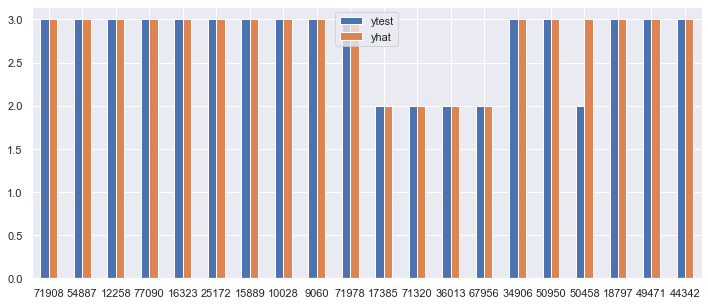

In [165]:
# create a temporary dataframe containing two columns
lin_df_tmp = pd.DataFrame({"ytest": y_accident_test[:20], "yhat": y_hat[:20]})
# plot the dataframe
lin_df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

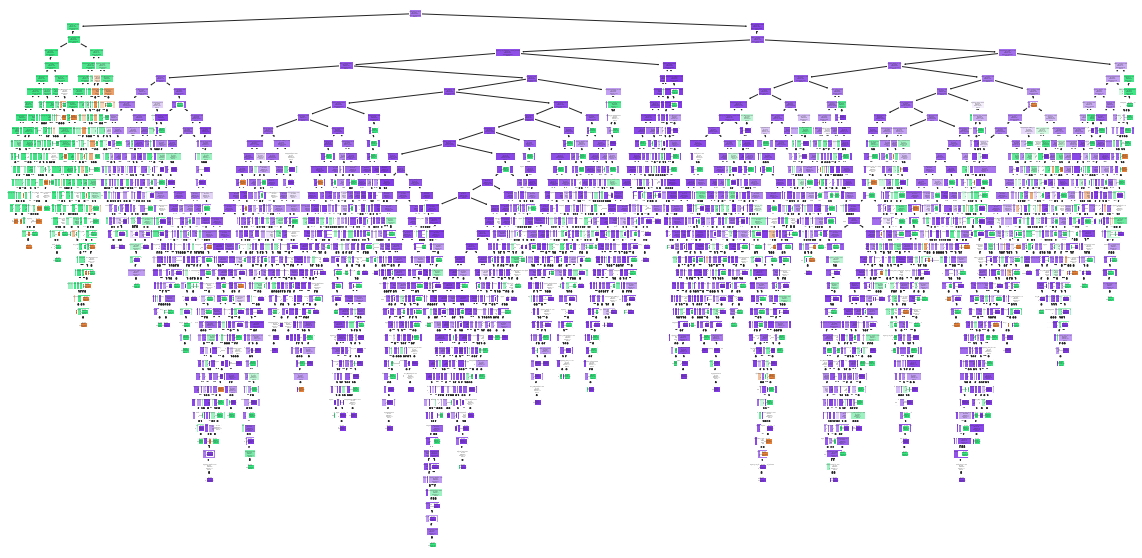

In [166]:
# plotting the decision tree to see how the depth
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(model ,feature_names=x_accident_train.columns,class_names=['1', "2",'3'], filled=True)
plt.show()

## Random Forest model

In [167]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 2 x 2 x 2 = 8 combinations in the grid
param_grid = {
    'n_estimators': [10, 200],
    'max_depth': [5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(x_accident_train, y_accident_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 193.03407764434814 seconds


In [168]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=7)

In [169]:
grid_search.best_score_

0.8903221022521095

In [170]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

5

In [171]:
rf_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    rf_split_test_scores.append(val)

In [172]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.901264,0.890322,1.214033
4,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.905083,0.888251,1.859736
7,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.892916,0.887949,0.556295
6,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 10}",0.892649,0.886655,0.671447
0,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.804847,0.805056,-0.025870
2,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}",0.796212,0.794212,0.251162
1,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.673502,0.666521,1.036493
3,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}",0.665837,0.657506,1.251187


In [173]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [174]:
import os
from joblib import dump
from joblib import load
# create a folder where all trained models will be kept
if not os.path.exists("models"): os.makedirs("models")
dump(grid_search.best_estimator_, 'models/rf_reg.joblib')

['models/rf_reg.joblib']

In [175]:
loaded_model = load('models/rf_reg.joblib')
y_hat_rf = loaded_model.predict(x_accident_test)

In [176]:
print(classification_report(y_accident_test, y_hat_rf))
print(confusion_matrix(y_accident_test, y_hat_rf))

              precision    recall  f1-score   support

           1       1.00      0.67      0.80       458
           2       0.98      0.82      0.89      5184
           3       0.95      1.00      0.97     18648

    accuracy                           0.95     24290
   macro avg       0.98      0.83      0.89     24290
weighted avg       0.96      0.95      0.95     24290

[[  308    71    79]
 [    0  4240   944]
 [    0     0 18648]]


In [177]:
score_rf = round(accuracy_score(y_hat_rf,y_accident_test)*100,2)
print("The accuracy score achieved using Random Forest is: "+str(score_rf)+" %")

from sklearn.metrics import f1_score
f1_rf = round(f1_score(y_hat_rf,y_accident_test, average='macro')*100,2)
print("The f1 score achieved using Random Forest is: "+str(f1_rf)+" %")

from sklearn.metrics import precision_score
pr_rf = round(precision_score(y_hat_rf,y_accident_test, average='macro')*100,2)
print("The precision score achieved using Random Forest is: "+str(pr_rf)+" %")

from sklearn.metrics import recall_score
re_rf = round(recall_score(y_hat_rf,y_accident_test, average='macro')*100,2)
print("The recall score achieved using Random Forest is: "+str(re_rf)+" %")

The accuracy score achieved using Random Forest is: 95.5 %
The f1 score achieved using Random Forest is: 89.02 %
The precision score achieved using Random Forest is: 83.01 %
The recall score achieved using Random Forest is: 97.72 %


<AxesSubplot:>

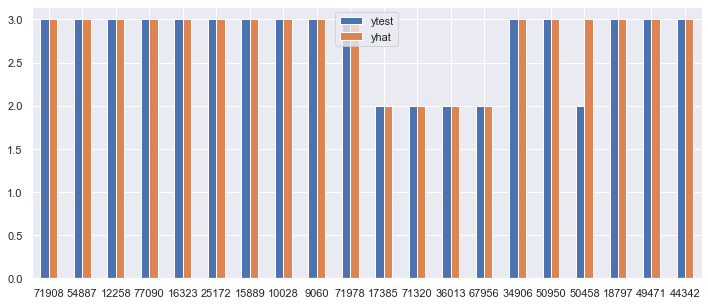

In [178]:
# create a temporary dataframe containing two columns
lin_df_tmp = pd.DataFrame({"ytest": y_accident_test[:20], "yhat": y_hat_rf[:20]})
# plot the dataframe
lin_df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [179]:
from sklearn.metrics import mean_absolute_error
MAE_rf = mean_absolute_error(y_accident_test, y_hat_rf)
print("MAE for random forest is : ", MAE_rf)

rf_cv_scores= cross_val_score(grid_search.best_estimator_, x_accident_train, y_accident_train, scoring="neg_mean_squared_error", cv=10)
rf_cv_rmse_scores = np.sqrt(-dt_cv_scores)
display_scores(rf_cv_rmse_scores)

rf_rmse_score=np.sqrt(-grid_search.best_score_)
print(f'The best random forest model has a RMSE of: {rf_rmse_score}')

MAE for random forest is :  0.04829147797447509
scores: [0.27107694 0.26433327 0.26682468 0.26665931 0.27190128]
Accuracy 0.26815909822765793
Standard deviation 0.0028700069804915756
The best random forest model has a RMSE of: nan


### SVM for classification

In [ ]:
from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7)

# specify the hyperparameters and their values
# 6 combinations in the grid
param_grid = {
    'C': [ 0.01, 0.1, 1, 5],
    'max_iter': [1000],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5, scoring='f1_macro', return_train_score=True) 

start = time.time()
grid_search.fit(x_accident_train, y_accident_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

In [ ]:
dump(grid_search.best_estimator_, 'models/svm_reg.joblib')

In [ ]:
loaded_model_svm = load('models/svm_reg.joblib')
y_hat_svm = loaded_model_svm.predict(x_accident_test)

In [ ]:
print(classification_report(y_accident_test, y_hat_svm))
print(confusion_matrix(y_accident_test, y_hat_svm))

In [ ]:
score_svm = round(accuracy_score(y_hat_svm,y_accident_test)*100,2)
print("The accuracy score achieved using SVM is: "+str(score_svm)+" %")

from sklearn.metrics import f1_score
f1_svm = round(f1_score(y_hat_svm,y_accident_test, average='macro')*100,2)
print("The f1 score achieved using SVM is: "+str(f1_svm)+" %")

from sklearn.metrics import precision_score
pr_svm = round(precision_score(y_hat_svm,y_accident_test, average='macro')*100,2)
print("The precision score achieved using SVM is: "+str(pr_svm)+" %")

from sklearn.metrics import recall_score
re_svm = round(recall_score(y_hat_svm,y_accident_test, average='macro')*100,2)
print("The recall score achieved using SVM is: "+str(re_svm)+" %")

In [ ]:
# create a temporary dataframe containing two columns
lin_df_tmp = pd.DataFrame({"ytest": y_accident_test[:20], "yhat": y_hat_svm[:20]})
# plot the dataframe
lin_df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE_svm = mean_absolute_error(y_accident_test, y_hat_svm)
print("MAE for svm is : ", MAE_svm)

svm_cv_scores= cross_val_score(grid_search.best_estimator_, x_accident_train, y_accident_train, scoring="neg_mean_squared_error", cv=5)
svm_cv_rmse_scores = np.sqrt(-svm_cv_scores)
display_scores(svm_cv_rmse_scores)


 ## KNN Classifier 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# building the knn classifier object
knn=KNeighborsClassifier()
# fitting the data into the model
knn.fit(x_accident_train,y_accident_train)
# using the model to predict outcome
y_pred_knn = knn.predict(x_accident_test)

In [ ]:
# Evaluate the model's performance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_accident_test, y_pred_knn))
print(confusion_matrix(y_accident_test, y_pred_knn))

### Hyper-parameter tuning the KNN classifier

In [ ]:
# Define the parameter grid for grid search CV
param_grid = {'n_neighbors':[1,10,30]}
# Initialize the KNN model
knn = KNeighborsClassifier()
# Initialize the grid search
grid_search = GridSearchCV(knn, param_grid, cv=5)
# Fit the grid search to the data
grid_search.fit(x_accident_train, y_accident_train)
# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_ * 100))

In [ ]:
# use the best parameters found by grid search to make predictions
y_hat_knn = grid_search.predict(x_accident_test)

In [ ]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

In [ ]:
score_knn = round(accuracy_score(y_hat_knn,y_accident_test)*100,2)
print("The accuracy score achieved using knn is: "+str(score_knn)+" %")

from sklearn.metrics import f1_score
f1_knn = round(f1_score(y_hat_knn,y_accident_test, average='macro')*100,2)
print("The f1 score achieved using knn is: "+str(f1_knn)+" %")

from sklearn.metrics import precision_score
pr_knn = round(precision_score(y_hat_knn,y_accident_test, average='macro')*100,2)
print("The precision score achieved using knn is: "+str(pr_knn)+" %")

from sklearn.metrics import recall_score
re_knn = round(recall_score(y_hat_knn,y_accident_test, average='macro')*100,2)
print("The recall score achieved using knn is: "+str(re_knn)+" %")

In [ ]:
# create a temporary dataframe containing two columns
lin_df_tmp = pd.DataFrame({"ytest": y_accident_test[:20], "yhat": y_hat_knn[:20]})
# plot the dataframe
lin_df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE_knn = mean_absolute_error(y_accident_test, y_hat_knn)
print("MAE for knn is : ", MAE_knn)

knn_cv_scores= cross_val_score(grid_search.best_estimator_, x_accident_train, y_accident_train, scoring="neg_mean_squared_error", cv=5)
knn_cv_rmse_scores = np.sqrt(-knn_cv_scores)
display_scores(knn_cv_rmse_scores)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg=LogisticRegression()

# specify the hyperparameters and their values
# 6 combinations in the grid
param_grid = {
              'C': [ 0.01, 1, 10],
              'solver': ['liblinear', 'saga'],
              'max_iter': [500] 
              }
                            

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='f1_macro', return_train_score=True) 

start = time.time()
grid_search.fit(x_accident_train, y_accident_train)
end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

In [ ]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

In [ ]:
lr_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    lr_split_test_scores.append(val)

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
import os
from joblib import dump
from joblib import load
# create a folder where all trained models will be kept
if not os.path.exists("models"): os.makedirs("models")
dump(grid_search.best_estimator_, 'models/lr_reg.joblib')

In [ ]:
loaded_model = load('models/lr_reg.joblib')
y_hat_lr = loaded_model.predict(x_accident_test)

In [ ]:
print(classification_report(y_accident_test, y_hat_lr))
print(confusion_matrix(y_accident_test, y_hat_lr))

In [ ]:
score_lr = round(accuracy_score(y_hat_lr,y_accident_test)*100,2)
print("The accuracy score achieved using LR is: "+str(score_lr)+" %")

from sklearn.metrics import f1_score
f1_lr = round(f1_score(y_hat_lr,y_accident_test, average='macro')*100,2)
print("The f1 score achieved using LR is: "+str(f1_lr)+" %")

from sklearn.metrics import precision_score
pr_lr = round(precision_score(y_hat_lr,y_accident_test, average='macro')*100,2)
print("The precision score achieved using LR is: "+str(pr_lr)+" %")

from sklearn.metrics import recall_score
re_lr = round(recall_score(y_hat_lr,y_accident_test, average='macro')*100,2)
print("The recall score achieved using LR is: "+str(re_lr)+" %")

In [ ]:
# create a temporary dataframe containing two columns
lin_df_tmp = pd.DataFrame({"ytest": y_accident_test[:20], "yhat": y_hat_lr[:20]})
# plot the dataframe
lin_df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE_lr = mean_absolute_error(y_accident_test, y_hat_lr)
print("MAE for logestic regression is : ", MAE_lr)

lr_cv_scores= cross_val_score(grid_search.best_estimator_, x_accident_train, y_accident_train, scoring="neg_mean_squared_error", cv=5)
lr_cv_rmse_scores = np.sqrt(-lr_cv_scores)
display_scores(lr_cv_rmse_scores)


# 13.Output final score

In [ ]:
scores = [score_svm,score_dt,score_rf, score_knn, score_lr]
algorithms = ["Support Vector Machine","Decision Tree","Random Forest" , "KNN" , "Logestic Regression"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms,scores)

In [ ]:
f1 = [f1_svm,f1_dt,f1_rf, f1_knn, f1_lr]
algorithms = ["Support Vector Machine","Decision Tree","Random Forest" , "KNN" , "Logestic Regression"]    

for i in range(len(algorithms)):
    print("The f1 score achieved using "+algorithms[i]+" is: "+str(f1[i])+" %")

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
plt.xlabel("Algorithms")
plt.ylabel("f1 score")

sns.barplot(algorithms,f1)

In [ ]:
re = [re_svm,re_dt,re_rf, re_knn, re_lr]
algorithms = ["Support Vector Machine","Decision Tree","Random Forest" , "KNN" , "Logestic Regression"]    

for i in range(len(algorithms)):
    print("The recall score achieved using "+algorithms[i]+" is: "+str(re[i])+" %")

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
plt.xlabel("Algorithms")
plt.ylabel("recall")

sns.barplot(algorithms,re)

In [ ]:
pr = [pr_svm,pr_dt,pr_rf, pr_knn, pr_lr]
algorithms = ["Support Vector Machine","Decision Tree","Random Forest" , "KNN" , "Logestic Regression"]    

for i in range(len(algorithms)):
    print("The precision score achieved using "+algorithms[i]+" is: "+str(pr[i])+" %")

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
plt.xlabel("Algorithms")
plt.ylabel("precision")

sns.barplot(algorithms,pr)

In [ ]:
print('Linear Regression')
display_scores(lr_cv_rmse_scores)
print('')
print('Decision Trees')
display_scores(dt_cv_rmse_scores)
print('')
print('Random Forest')
display_scores(rf_cv_rmse_scores)
print('')
print('Support Vector Regression')
display_scores(svm_cv_rmse_scores)
print('')
print('KNN')
display_scores(knn_cv_rmse_scores)

When comparing the performance of different machine learning algorithms, it is important to consider not only their accuracy, but also their standard deviation. The standard deviation gives an indication of the variability of the algorithm's performance across different runs or cross-validation folds.

We can see that the decision trees and random forest algorithms have the lowest standard deviation, which suggests that their performance is more consistent across different runs or folds of the data. This is followed by KNN, while linear regression and support vector regression have the highest standard deviation, indicating that their performance is more variable.

A low standard deviation indicates that the performance of the algorithm is consistent across different runs or cross-validation folds.

In [ ]:
# Finish Timer
notebook_duration = round((time.time() - start)/60, 5)
print(f'The completion of the notebook took {notebook_duration} minutes.')

# 14.Conclusion


The use of 3 databases and feature engineering improved the performance of the model significantly in all calcification models.
Out of the various models that were evaluated the Random Forest Classifier had the best results when it was evaluated using training data (based on accuracy , recall , f1 score). Also decision tree showed best precision overall.
